# Rafael Piazenski
## Time Series - Como a série evolui ao longo do tempo!

### Objetivos:

1. Descrever a série temporal de acordo com as suas propriedades e componentes.
   Isto inclui a tendência, sazonalidade, estacionariedade, entre outros.
2. Descrever a estrutura do modelo ARIMA que melhor se ajusta aos dados.
3. Avaliar o desempenho de um modelo de regressão com validação cruzada.
4. Descrever o impacto dos seguintes aspectos no desempenho:
   4. 1. diferentes horizontes temporais;
   4. 2. desempenho nos valores extremos da série;
   4. 3. comparação de diferentes algoritmos de regressão.

## Bibliotecas Requeridas

In [1]:
%pip install --upgrade numpy==1.26.4
%pip install --upgrade pandas
%pip install --upgrade matplotlib
%pip install --upgrade statsmodels
%pip install --upgrade pmdarima
%pip install --upgrade scikit-learn
%pip install --upgrade seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Descrição

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
data = pd.read_csv('assets/energy_load_pt.csv')
# dimensão dos dados
data.shape

(13104, 2)

In [4]:
data.head()

datetime    load
0  2020-11-17 08:00:00  5159.0
1  2020-11-17 09:00:00  4985.0
2  2020-11-17 10:00:00  4717.0
3  2020-11-17 11:00:00  4356.0
4  2020-11-17 12:00:00  4086.0

<Axes: xlabel='datetime'>

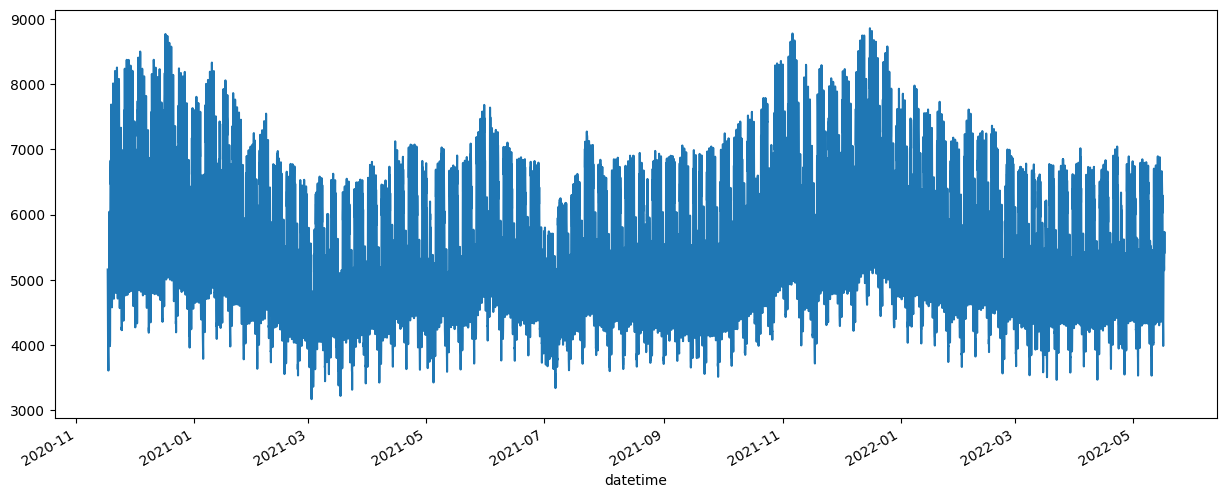

In [5]:
series = pd.Series(data['load'])
series.index = pd.to_datetime(data['datetime'])
series.plot(figsize=(15, 6))


In [6]:
series_d = series.resample('D').mean()

<Axes: xlabel='datetime'>

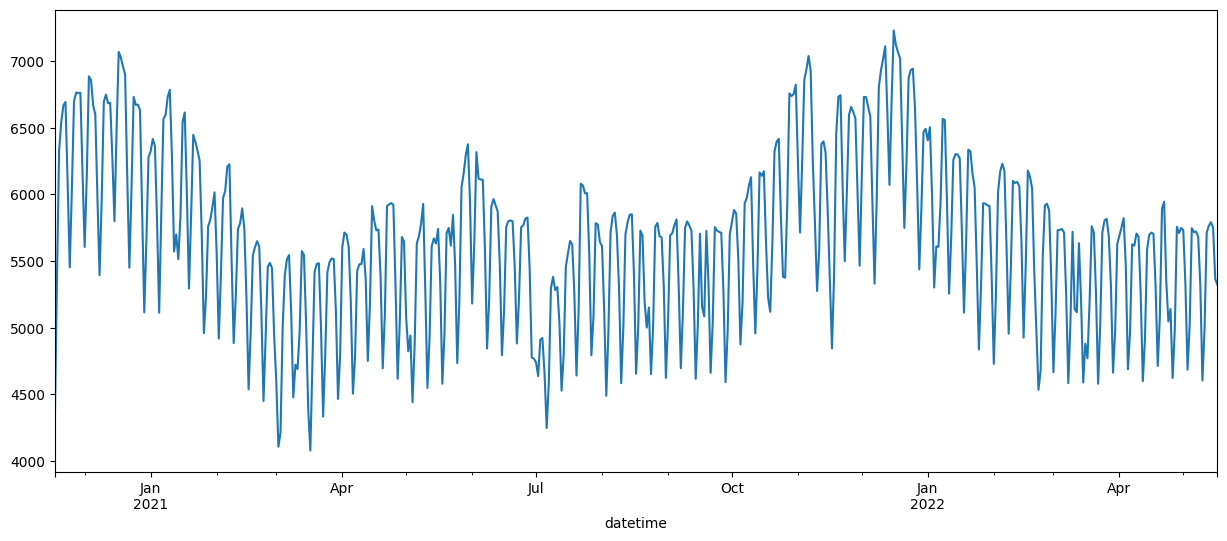

In [7]:
series_d.plot(figsize=(15, 6))

<Axes: xlabel='datetime'>

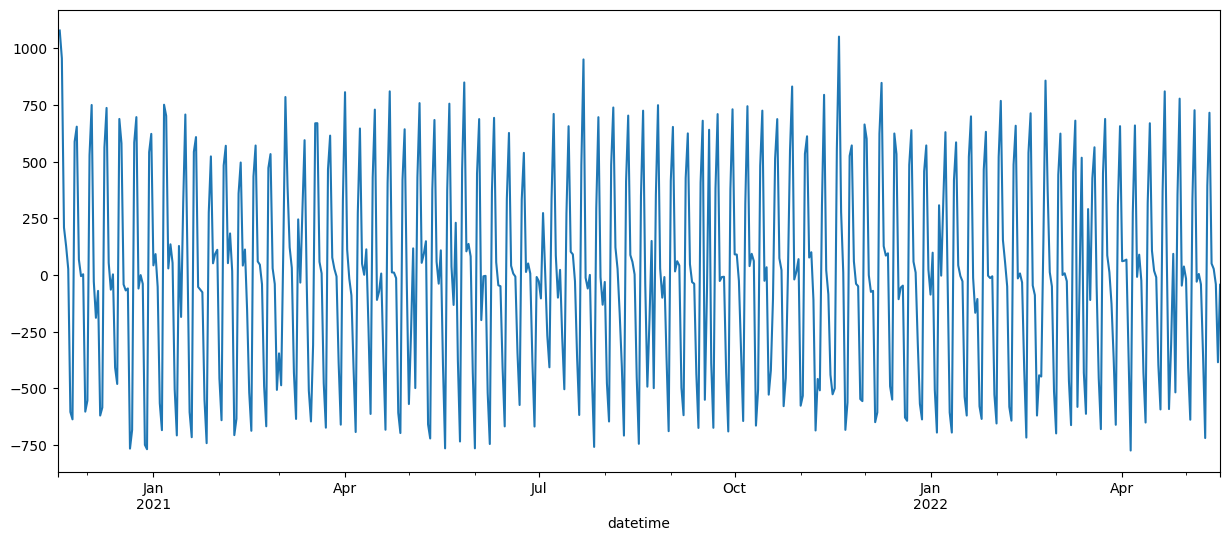

In [8]:
series_d.diff().plot(figsize=(15, 6))

<Axes: >

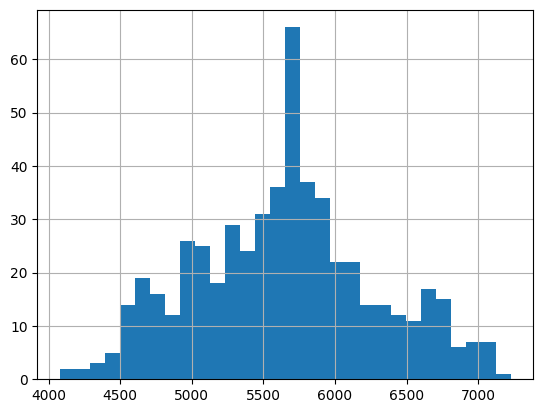

In [9]:
series_d.hist(bins=30)

In [10]:
from pmdarima.arima import ndiffs, nsdiffs

# kpss test
ndiffs(series_d, test='kpss')

1

In [11]:
ndiffs(series_d.diff()[1:], test='kpss')

0

In [12]:
# augmented dickey-fuller
ndiffs(series_d, test='adf')

1

In [13]:
# testes para sazonalidade
nsdiffs(series_d, test='ocsb', m=12)

0

In [14]:
nsdiffs(series_d, test='ch', m=12)

0

<Axes: xlabel='datetime'>

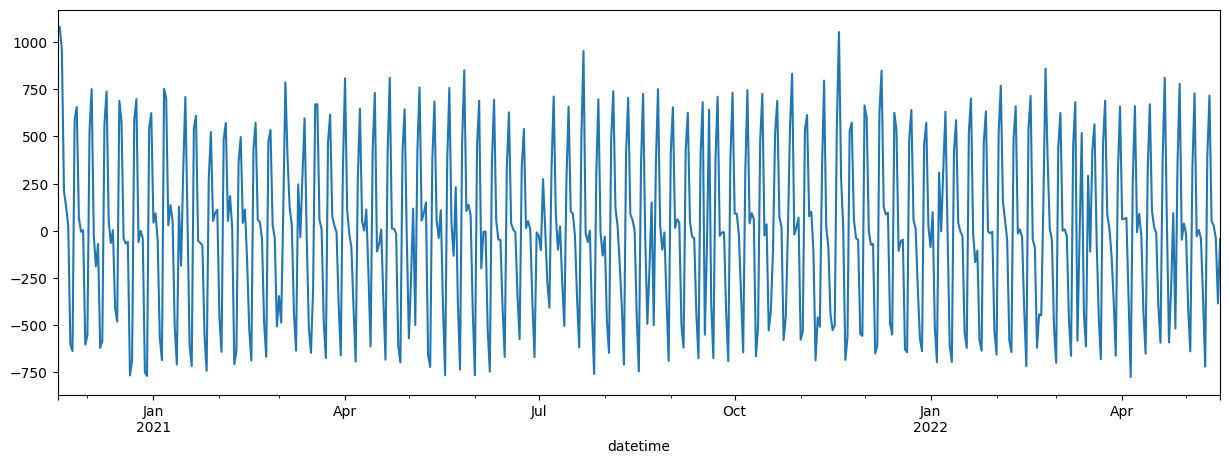

In [15]:
# removendo a tendencia
series_d.diff(periods=1).plot(figsize=(15,5))

<Axes: xlabel='datetime'>

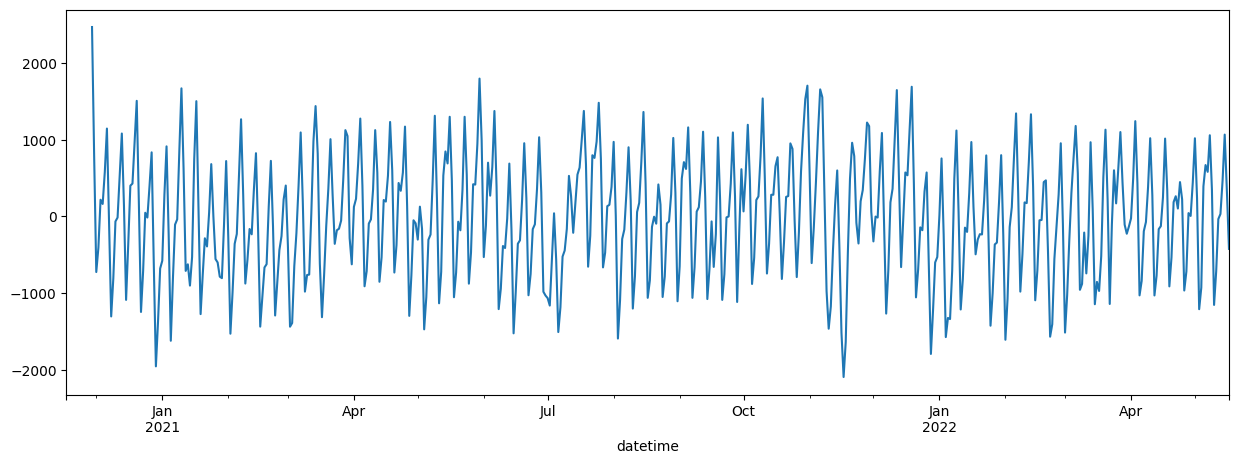

In [16]:
# removendo a sazonalidade
series_d.diff(periods=12).plot(figsize=(15,5))

<Axes: xlabel='datetime'>

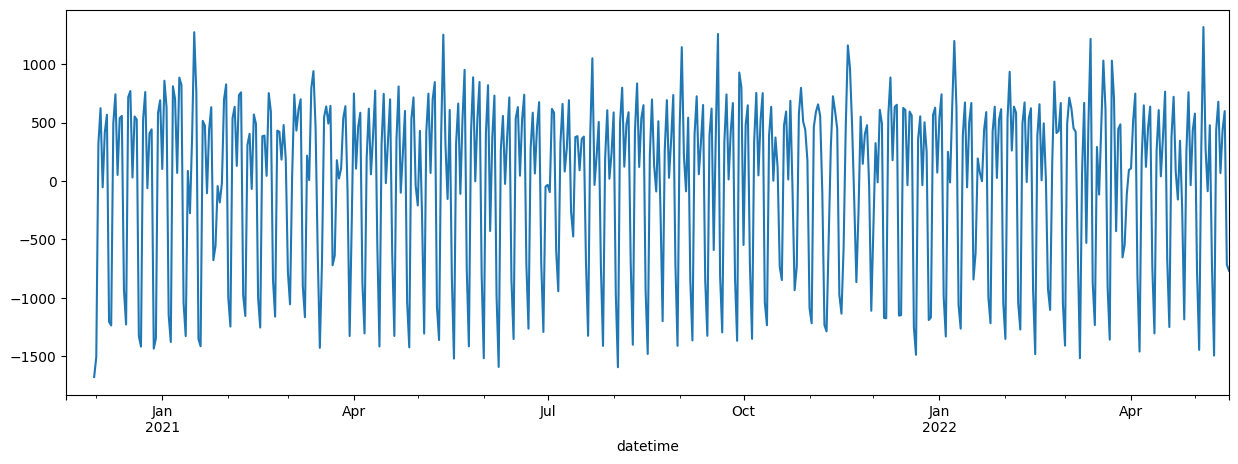

In [17]:
# residuos
series_d.diff(periods=1).diff(periods=12).plot(figsize=(15,5))

Axes(0.125,0.11;0.775x0.77)


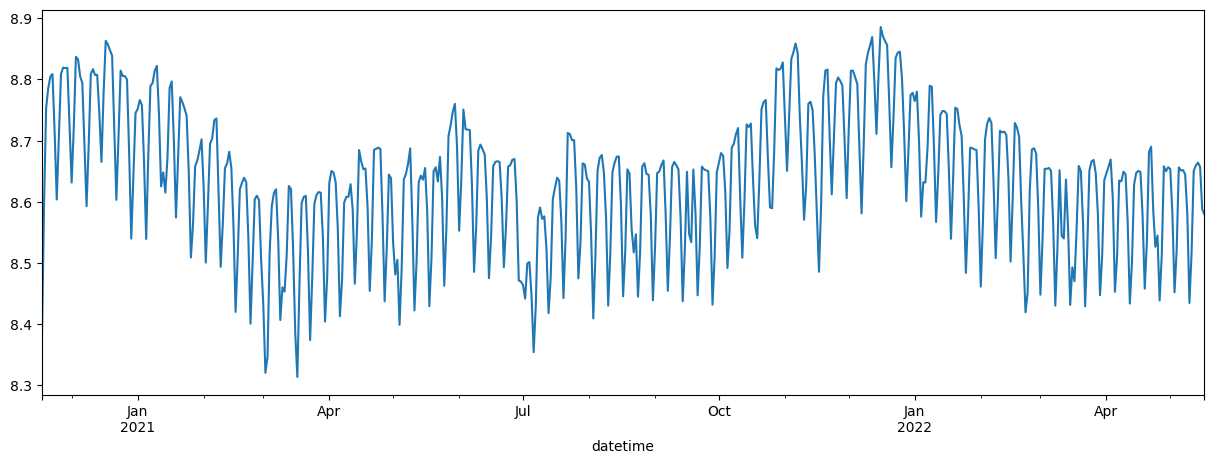

In [18]:
series_log = np.log(series_d)

print(series_log.plot(figsize=(15,5)))

datetime
2020-11-17    4294.687500
2020-11-18    5373.125000
2020-11-19    6329.000000
2020-11-20    6538.708333
2020-11-21    6666.208333
                 ...     
2022-05-13    5763.750000
2022-05-14    5791.000000
2022-05-15    5750.458333
2022-05-16    5365.791667
2022-05-17    5323.111111
Freq: D, Name: load, Length: 547, dtype: float64


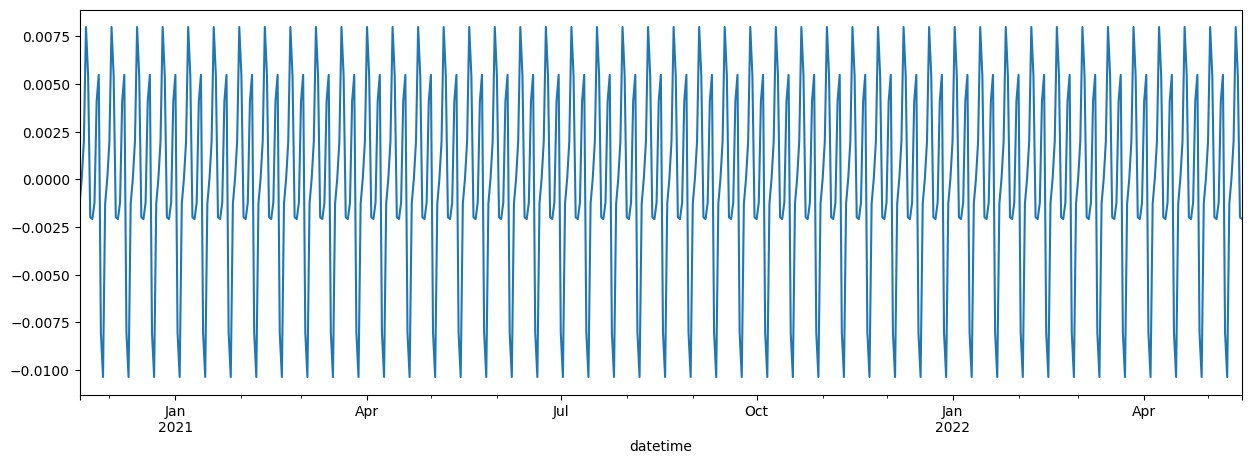

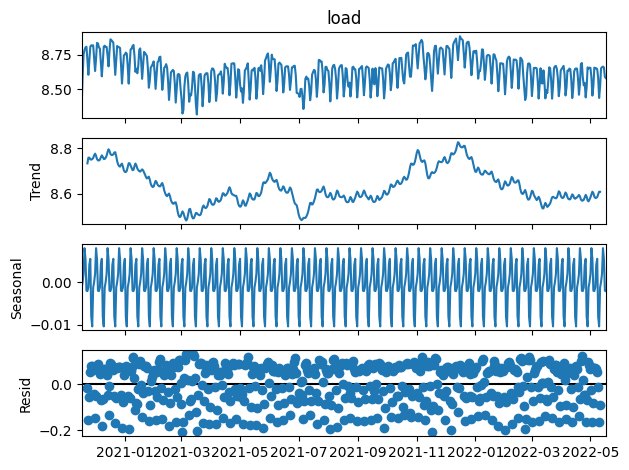

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

print(np.exp(series_log))

result = seasonal_decompose(series_log,
                            model='add',
                            period=12)

result.seasonal.plot(figsize=(15,5))

plt = result.plot()

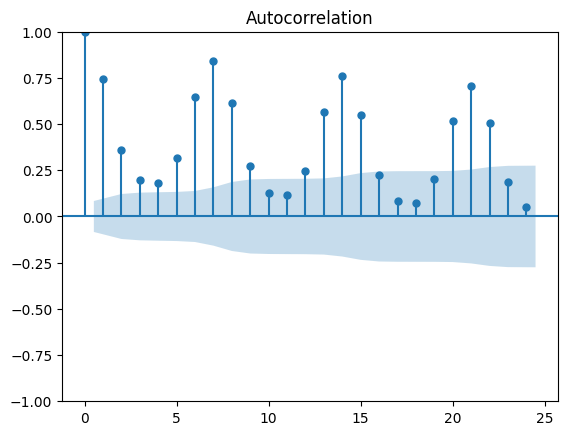

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt = plot_acf(series_d, lags=24)

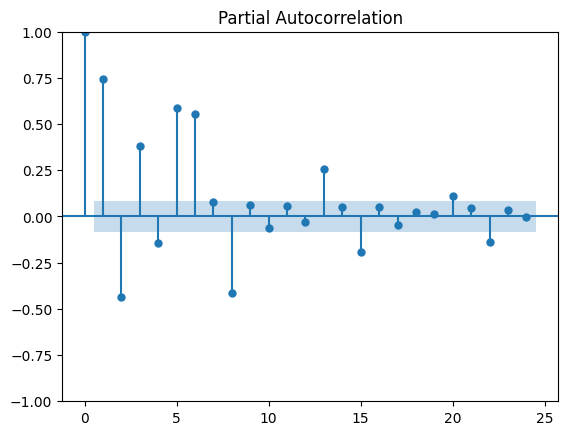

In [21]:
plt = plot_pacf(series_d, lags=24)

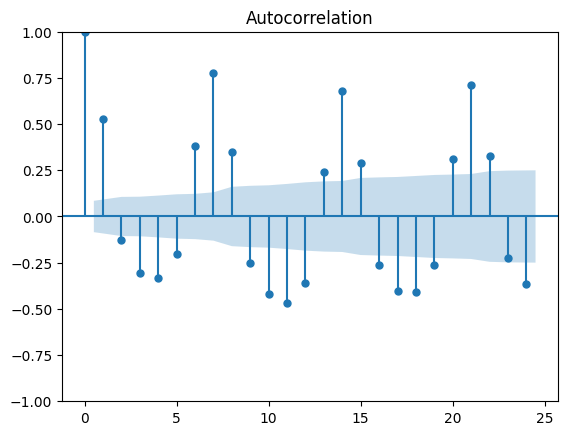

In [22]:
plt = plot_acf(series_d.diff(periods=12)[13:], lags=24)

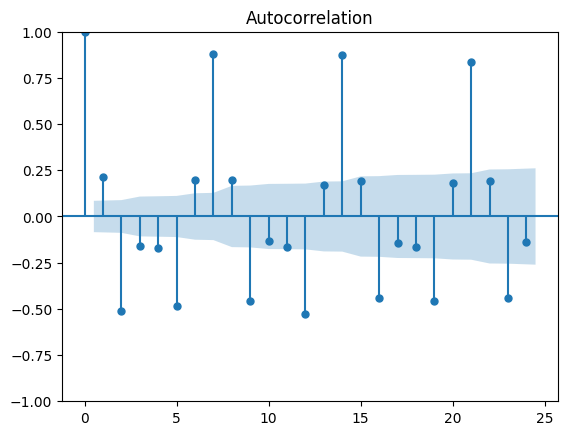

In [23]:
plt = plot_acf(series_d.diff().diff(periods=12)[13:], lags=24)


In [24]:
# heterocedastidade
from src.heteroskedasticity import het_tests

p_value = het_tests(series_d, test='white')
#p_value = het_tests(series, test='breuschpagan')

# se abaixo de 0.05, então considerar que a serie é heterocedastica
p_value

0.04562029433985686

In [25]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# box-cox
transformed_data, best_lambda = boxcox(series_d)

print(transformed_data[:5])
print(series.values[:5])
print(best_lambda)

[189.5682972  215.07168945 235.83594415 240.2013776  242.82531482]
[5159. 4985. 4717. 4356. 4086.]
0.5584578534349353


<Axes: >

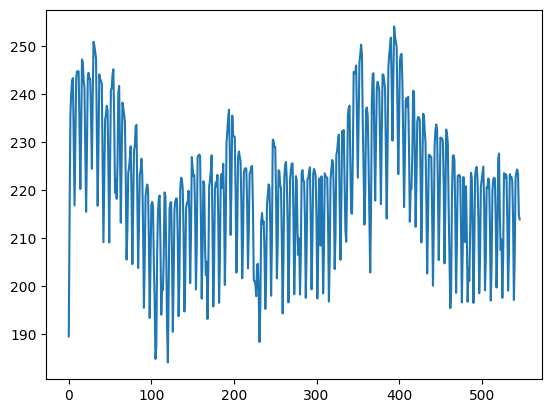

In [26]:
pd.Series(transformed_data).plot()

<Axes: >

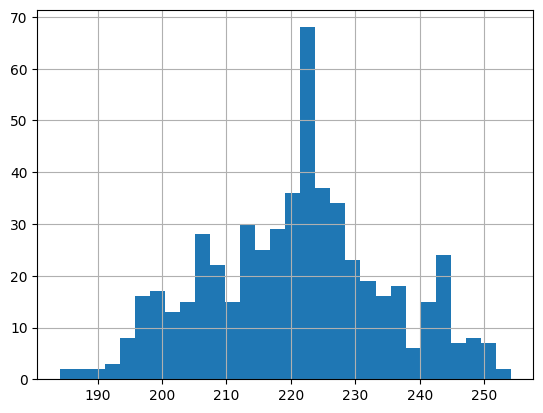

In [27]:
pd.Series(transformed_data).hist(bins=30)

## 2. Modelo ARIMA

In [28]:
# divisao entre treino e validacao
from sklearn.model_selection import train_test_split

train, test = train_test_split(series_d, shuffle=False, test_size=24)

In [29]:
train.tail()

datetime
2022-04-19    4713.125000
2022-04-20    5082.458333
2022-04-21    5892.458333
2022-04-22    5944.333333
2022-04-23    5353.125000
Freq: D, Name: load, dtype: float64

In [30]:
test.head()

datetime
2022-04-24    5046.750000
2022-04-25    5140.208333
2022-04-26    4622.708333
2022-04-27    4978.291667
2022-04-28    5756.291667
Freq: D, Name: load, dtype: float64

In [31]:
# auto arima
import pmdarima as pm

model = pm.auto_arima(train, m=12, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7422.384, Time=10.14 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7864.728, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7723.045, Time=2.73 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7585.747, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7862.739, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7421.655, Time=7.28 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7440.325, Time=2.51 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=7421.843, Time=19.75 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7425.262, Time=9.16 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=21.81 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=7444.563, Time=7.66 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=7554.971, Time=8.96 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=7391.313, Time=8.20 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=7431.442, Time=1.23 sec
 ARIMA(3,1,2)(1,0,1)[

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  523
Model:             SARIMAX(5, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -3533.463
Date:                            Fri, 26 Jul 2024   AIC                           7088.927
Time:                                    10:41:43   BIC                           7135.761
Sample:                                11-17-2020   HQIC                          7107.271
                                     - 04-23-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3242      0.094      3.450      0.001       0.140       0.508
ar.L2         -1.0010      0.073    -13.755      0.000      -1.144      -0.858
ar.L3          0.0750      0.114      0.655      0.512      -0.149       0.299
ar.L4         -0.5579      0.062     -8.996      0.000      -0.679      -0.436
ar.L5         -0.4284      0.080     -5.347      0.000      -0.585      -0.271
ma.L1         -0.1755      0.096     -1.832      0.067      -0.363       0.012
ma.L2          0.3755      0.071      5.281      0.000       0.236       0.515
ar.S.L12      -0.3751      0.281     -1.335      0.182      -0.926       0.176
ma.S.L12       0.4599      0.282      1.628      0.103      -0.094       1.014
ma.S.L24       0.1820      0.061      3.006      0.003       0.063       0.301
sigma2      4.764e+04   2627.159     18.133      0.000    4.25e+04    5.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                87.60
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.07
Prob(H) (two-sided):                  0.94   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

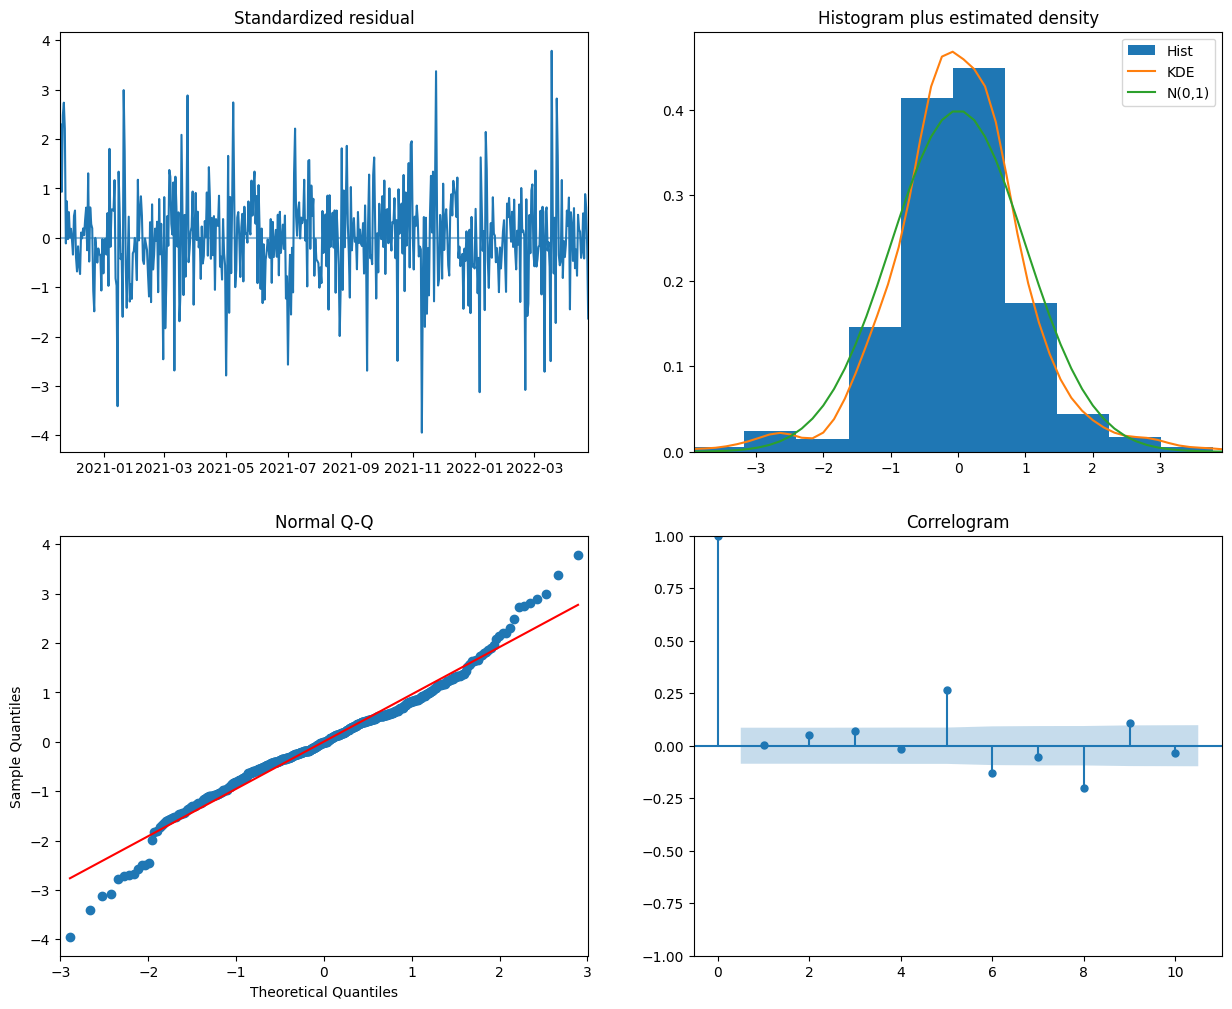

In [33]:
plot=model.plot_diagnostics(figsize=(15, 12))

In [34]:
forecasts = model.predict(24)
forecasts.index = pd.to_datetime(forecasts.index)
forecasts = forecasts.rename('Forecasts') 

forecasts


2022-04-24    5240.677315
2022-04-25    5049.092223
2022-04-26    4686.700624
2022-04-27    5088.959912
2022-04-28    5855.254885
2022-04-29    5775.831159
2022-04-30    5332.221779
2022-05-01    5226.235383
2022-05-02    5049.969717
2022-05-03    4794.071232
2022-05-04    5136.943364
2022-05-05    5728.912887
2022-05-06    5677.228079
2022-05-07    5323.458570
2022-05-08    5212.483077
2022-05-09    5049.629151
2022-05-10    4852.919063
2022-05-11    5176.880585
2022-05-12    5682.636587
2022-05-13    5632.993808
2022-05-14    5352.490980
2022-05-15    5260.139800
2022-05-16    5096.638294
2022-05-17    4875.981620
Freq: D, Name: Forecasts, dtype: float64

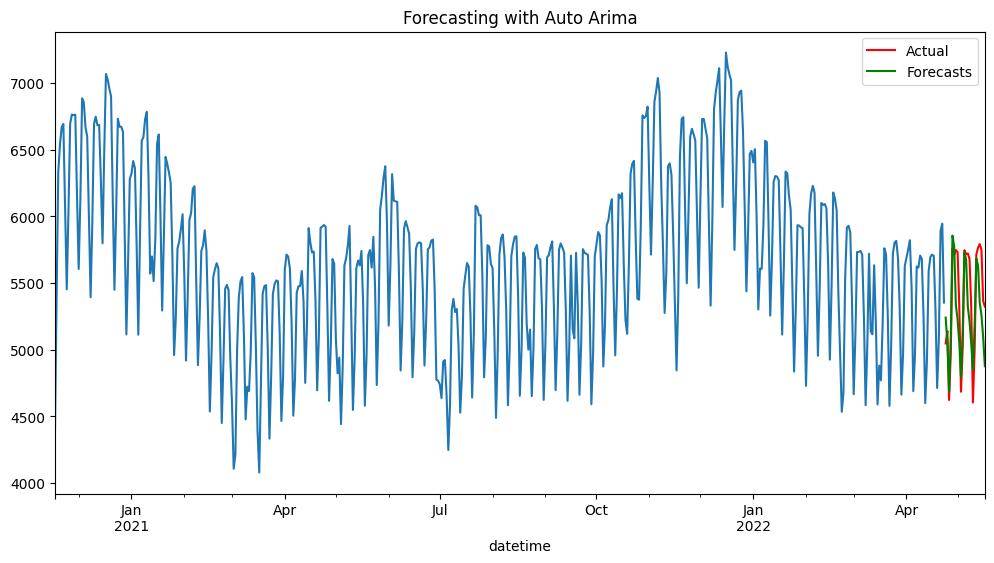

In [35]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

test = test.rename('Actual')

# forecasts_s = pd.Series(forecasts, index=test.index).rename('Forecasts')

ax = train.plot()
ax = test.plot(legend=True, color='red', figsize=(12,6),title='Forecasting with Auto Arima')
ax = forecasts.plot(legend=True, color='green')

In [36]:
# computing the error
from src.error import MASE

err = MASE(train, test, forecasts)

err

0.6355139672071649

In [37]:
AR = pm.ARIMA(order=(1,0,0))
MA = pm.ARIMA(order=(0,0,1))

AR.fit(train)

ARIMA(order=(1, 0, 0))

In [38]:
AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  523
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3904.223
Date:                Fri, 26 Jul 2024   AIC                           7814.447
Time:                        10:41:45   BIC                           7827.225
Sample:                    11-17-2020   HQIC                          7819.451
                         - 04-23-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1431.3120    190.413      7.517      0.000    1058.109    1804.515
ar.L1          0.7469      0.034     21.921      0.000       0.680       0.814
sigma2       1.77e+05   1.39e+04     12.704      0.000     1.5e+05    2.04e+05
===================================================================================
Ljung-Box (L1) (Q):                  58.52   Jarque-Bera (JB):                13.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.18
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

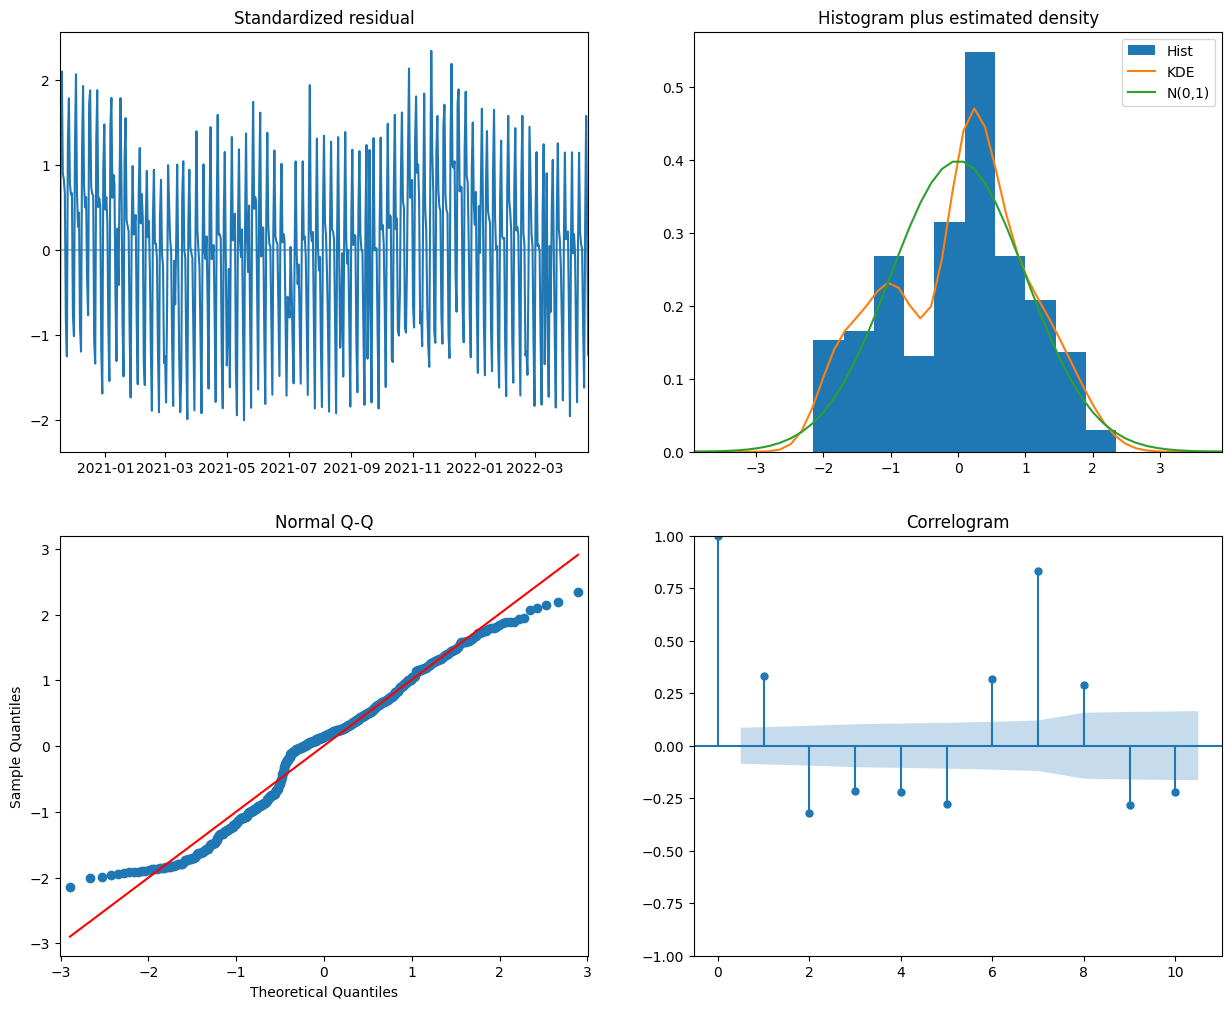

In [39]:
plot=AR.plot_diagnostics(figsize=(15, 12))

In [40]:
MA.fit(train)

MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  523
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3847.971
Date:                Fri, 26 Jul 2024   AIC                           7701.941
Time:                        10:41:47   BIC                           7714.720
Sample:                    11-17-2020   HQIC                          7706.946
                         - 04-23-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5659.9474     32.546    173.907      0.000    5596.159    5723.736
ma.L1          0.9452      0.015     61.604      0.000       0.915       0.975
sigma2      1.433e+05   9825.896     14.585      0.000    1.24e+05    1.63e+05
===================================================================================
Ljung-Box (L1) (Q):                 132.57   Jarque-Bera (JB):                 5.15
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               0.95   Skew:                            -0.18
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

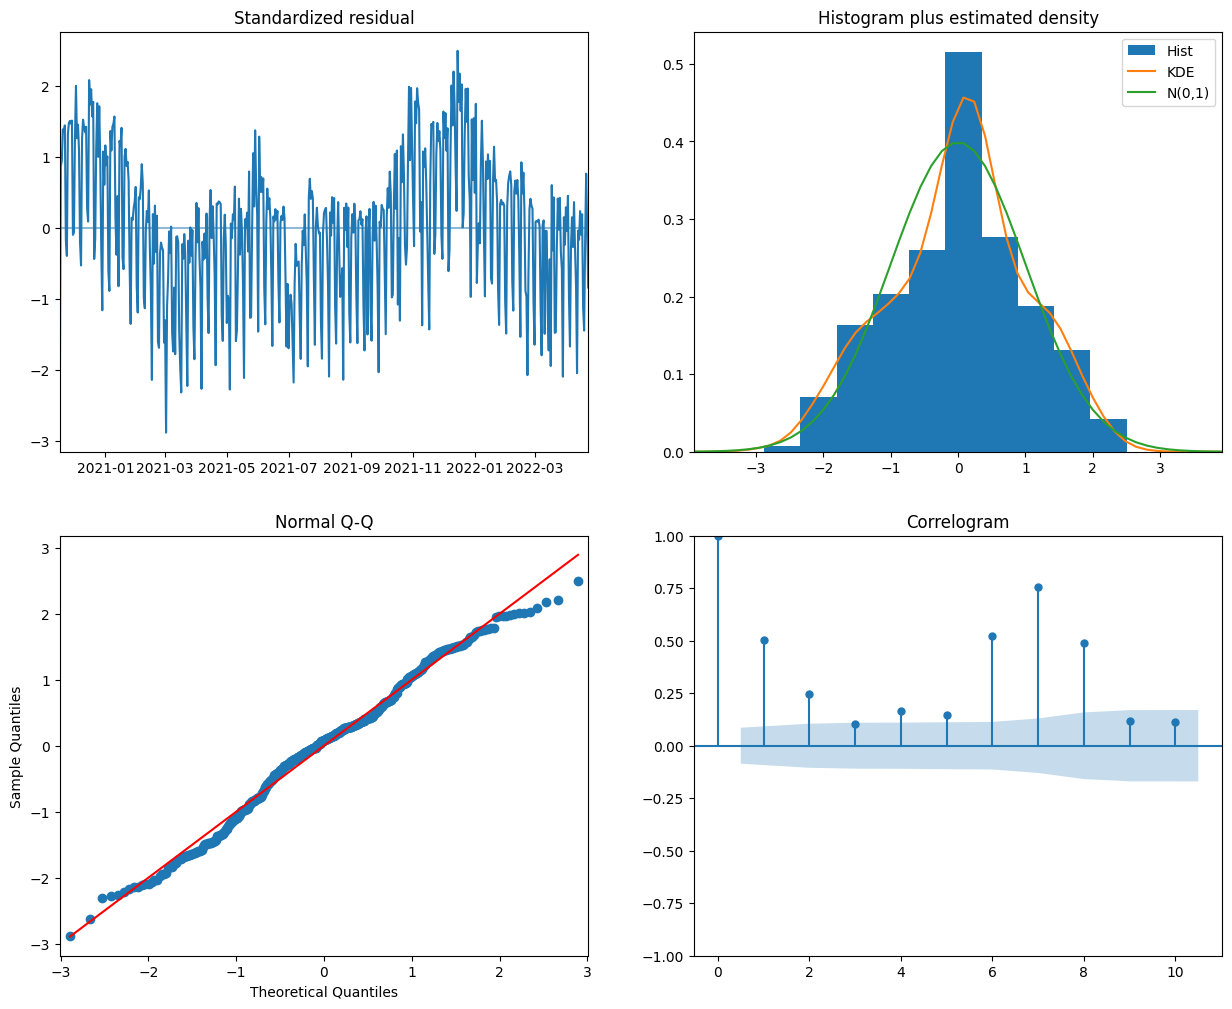

In [41]:
plot=MA.plot_diagnostics(figsize=(15, 12))

<Axes: title={'center': 'Forecasting with AR'}, xlabel='datetime'>

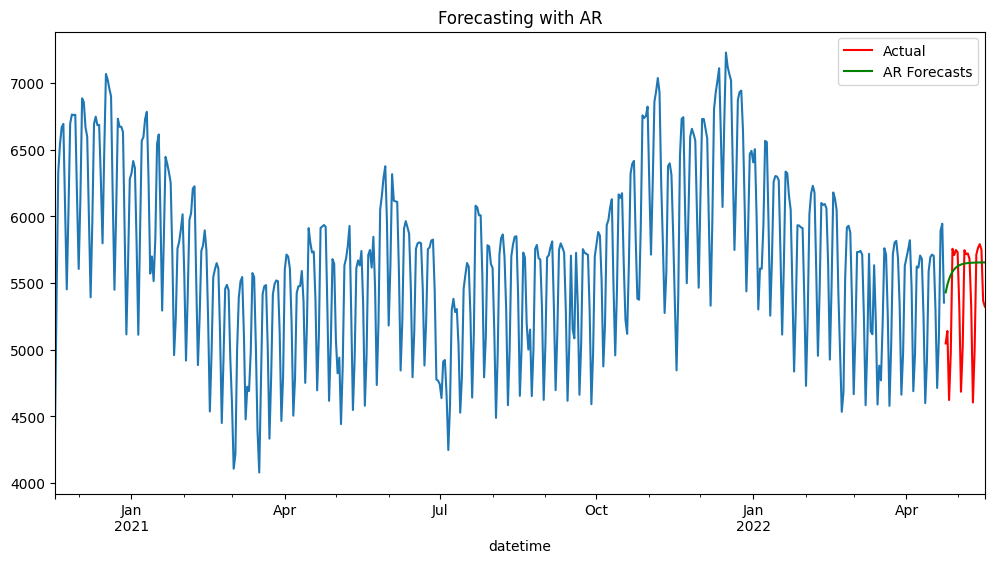

In [42]:
forecasts = AR.predict(24)
forecasts = pd.Series(forecasts, index=test.index).rename('AR Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with AR')
forecasts.plot(legend=True, color='green')


In [43]:
err = MASE(train, test, forecasts)

err

0.9225716542677672

In [44]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel


ses_model_manual = SimpleExpSmoothing(train, initialization_method="heuristic").fit(smoothing_level=0.5, optimized=False)

ses_model_auto = SimpleExpSmoothing(train, initialization_method="estimated").fit()

/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [45]:
ses_model_manual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                   load   No. Observations:                  523
Model:             SimpleExpSmoothing   SSE                      132556065.495
Optimized:                      False   AIC                           6511.655
Trend:                           None   BIC                           6520.174
Seasonal:                        None   AICC                          6511.732
Seasonal Periods:                None   Date:                 Fri, 26 Jul 2024
Box-Cox:                        False   Time:                         10:41:49
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5000000                alpha                False
initial_level              5331.5944                  l.0                False
------------------------------------------------------------------------------
"""

In [46]:
ses_model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                   load   No. Observations:                  523
Model:             SimpleExpSmoothing   SSE                      107325101.775
Optimized:                       True   AIC                           6401.227
Trend:                           None   BIC                           6409.746
Seasonal:                        None   AICC                          6401.304
Seasonal Periods:                None   Date:                 Fri, 26 Jul 2024
Box-Cox:                        False   Time:                         10:41:49
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              5331.5944                  l.0                 True
------------------------------------------------------------------------------
"""

In [47]:
ses_forecasts = ses_model_auto.forecast(24)

print(MASE(train,test,ses_forecasts))

0.9771983414758831


<Axes: title={'center': 'Forecasting with SES'}, xlabel='datetime'>

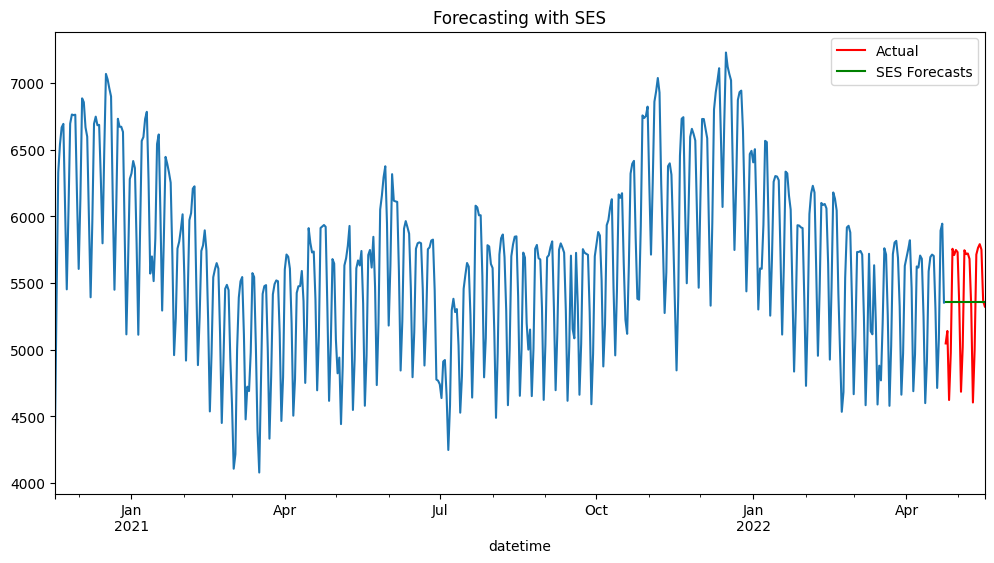

In [48]:
ses_forecasts = pd.Series(ses_forecasts, index=test.index).rename('SES Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with SES')
ses_forecasts.plot(legend=True, color='green')


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


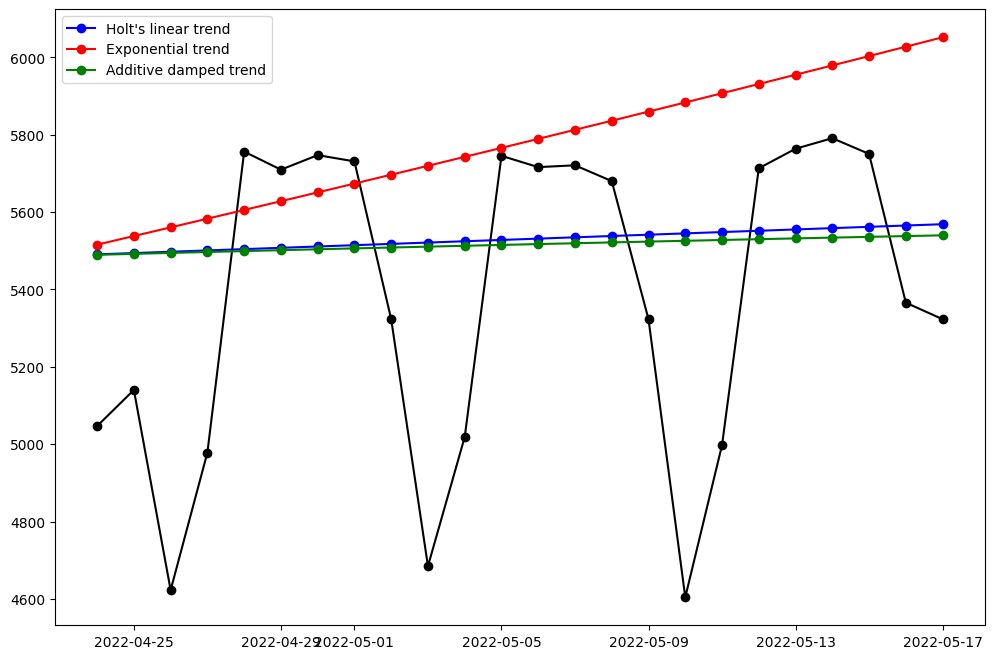

In [49]:
holt_model1 = Holt(train, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
forecasts_holt_m1 = holt_model1.forecast(24).rename("Holt's linear trend")


holt_model2 = Holt(train, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
forecasts_holt_m2 = holt_model2.forecast(24).rename("Exponential trend")


holt_model3 = Holt(train, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
forecasts_holt_m3 = holt_model3.forecast(24).rename("Additive damped trend")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(test, marker="o", color="black")
(line1,) = plt.plot(forecasts_holt_m1, marker="o", color="blue")
(line2,) = plt.plot(forecasts_holt_m2, marker="o", color="red")
(line3,) = plt.plot(forecasts_holt_m3, marker="o", color="green")
plt.legend([line1, line2, line3], [forecasts_holt_m1.name, forecasts_holt_m2.name, forecasts_holt_m3.name])

In [50]:
# Holt’s Winters Seasonal Exponential Smoothing
es = ExponentialSmoothing(
    train,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=False,
    initialization_method="estimated",
).fit()

forecasts_es = es.forecast(24).rename("Holt’s Winters Seasonal Exponential Smoothing")


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


1.057196405631865


<Axes: title={'center': 'Forecasting with ES'}, xlabel='datetime'>

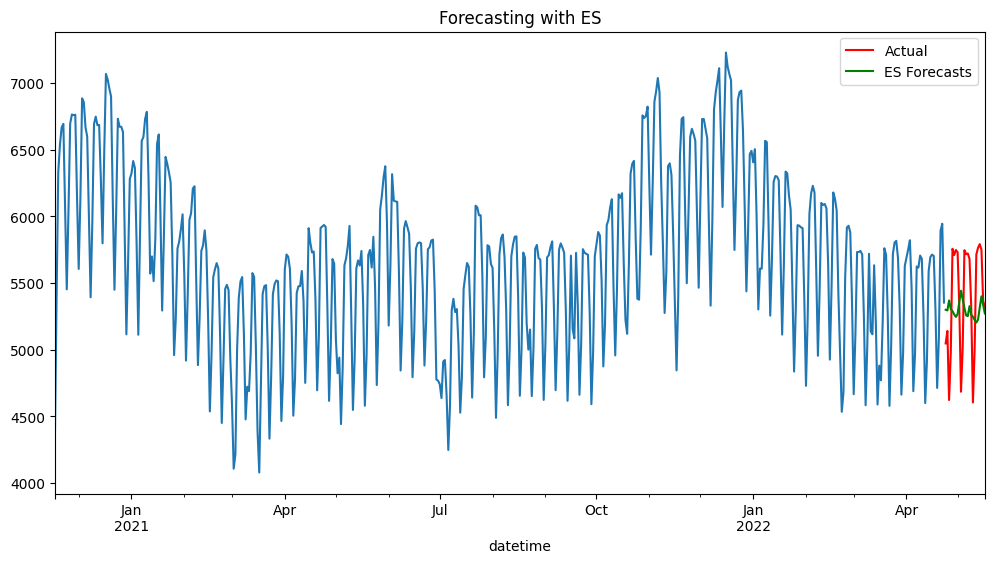

In [51]:
print(MASE(train,test,forecasts_es))

forecasts_es = forecasts_es.rename('ES Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with ES')
forecasts_es.plot(legend=True, color='green')

In [52]:
ets = ETSModel(
    train,
    seasonal_periods=12,
    trend="mul",
    seasonal="mul",
    initialization_method="estimated",
).fit()

forecasts_ets = ets.forecast(24).rename("ETS")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69261D+00    |proj g|=  2.81349D-01

At iterate    1    f=  7.68590D+00    |proj g|=  1.11630D+00

At iterate    2    f=  7.67810D+00    |proj g|=  1.69252D-01

At iterate    3    f=  7.67415D+00    |proj g|=  1.36647D-01

At iterate    4    f=  7.66515D+00    |proj g|=  4.80753D-01

At iterate    5    f=  7.65900D+00    |proj g|=  8.56205D-01

At iterate    6    f=  7.64863D+00    |proj g|=  4.12820D-01

At iterate    7    f=  7.64303D+00    |proj g|=  4.29310D-01

At iterate    8    f=  7.63966D+00    |proj g|=  2.12686D+00

At iterate    9    f=  7.63939D+00    |proj g|=  6.29073D-01

At iterate   10    f=  7.63746D+00    |proj g|=  3.45121D-02

At iterate   11    f=  7.63744D+00    |proj g|=  1.93363D-02

At iterate   12    f=  7.63742D+00    |proj g|=  3.03610D-02

At iterate   13    f=  7.6

In [53]:
ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                   load   No. Observations:                  523
Model:                       ETS(AMM)   Log Likelihood               -3994.261
Date:                Fri, 26 Jul 2024   AIC                           8024.521
Time:                        10:41:51   BIC                           8101.194
Sample:                    11-17-2020   HQIC                          8054.550
                         - 04-23-2022   Scale                       251838.295
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.1559      0.024      6.609      0.000       0.110       0.202
smoothing_trend      1.559e-05        nan        nan        nan         nan         nan
smoothing_seasonal   8.441e-05        nan        nan        nan         nan         nan
initial_level        6277.2846        nan        nan        nan         nan         nan
initial_trend           0.9997      0.001   1786.453      0.000       0.999       1.001
initial_seasonal.0      0.9942        nan        nan        nan         nan         nan
initial_seasonal.1      0.9978        nan        nan        nan         nan         nan
initial_seasonal.2      1.0122        nan        nan        nan         nan         nan
initial_seasonal.3      1.0066        nan        nan        nan         nan         nan
initial_seasonal.4      1.0037        nan        nan        nan         nan         nan
initial_seasonal.5      1.0012        nan        nan        nan         nan         nan
initial_seasonal.6      1.0059        nan        nan        nan         nan         nan
initial_seasonal.7      1.0138        nan        nan        nan         nan         nan
initial_seasonal.8      1.0131        nan        nan        nan         nan         nan
initial_seasonal.9      1.0045        nan        nan        nan         nan         nan
initial_seasonal.10     0.9993        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                     2509.54   Jarque-Bera (JB):                31.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.54
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

0.9799808658205093


<Axes: title={'center': 'Forecasting with ETS'}, xlabel='datetime'>

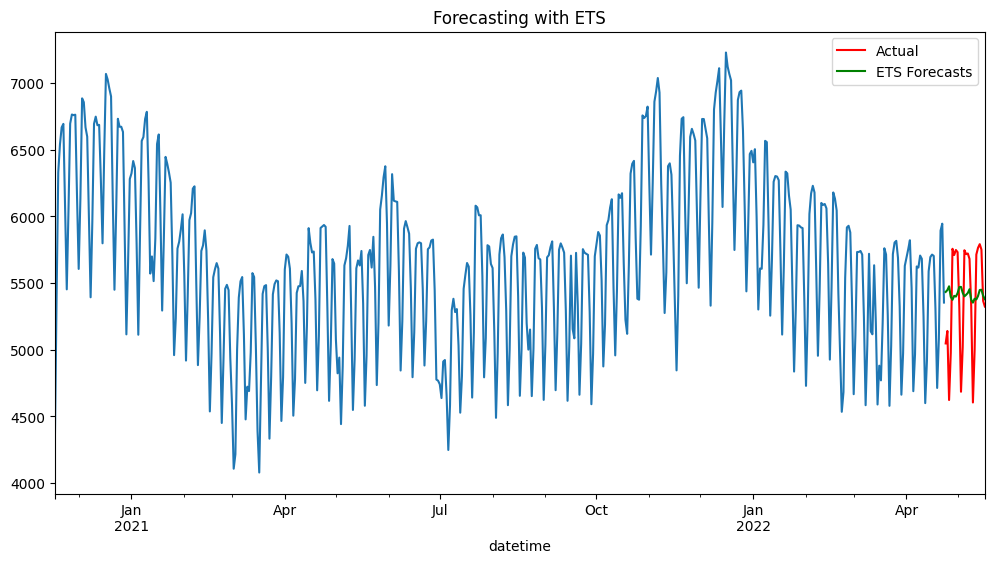

In [54]:
print(MASE(train,test,forecasts_ets))

forecasts_ets = forecasts_ets.rename('ETS Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with ETS')
forecasts_ets.plot(legend=True, color='green')


Percebemos que o melhor modelo de previsão é o AUTO-ARIMA - Best model:  ARIMA(5,1,2)(1,0,2)[12]

## Validação Cruzada

<Axes: xlabel='datetime'>

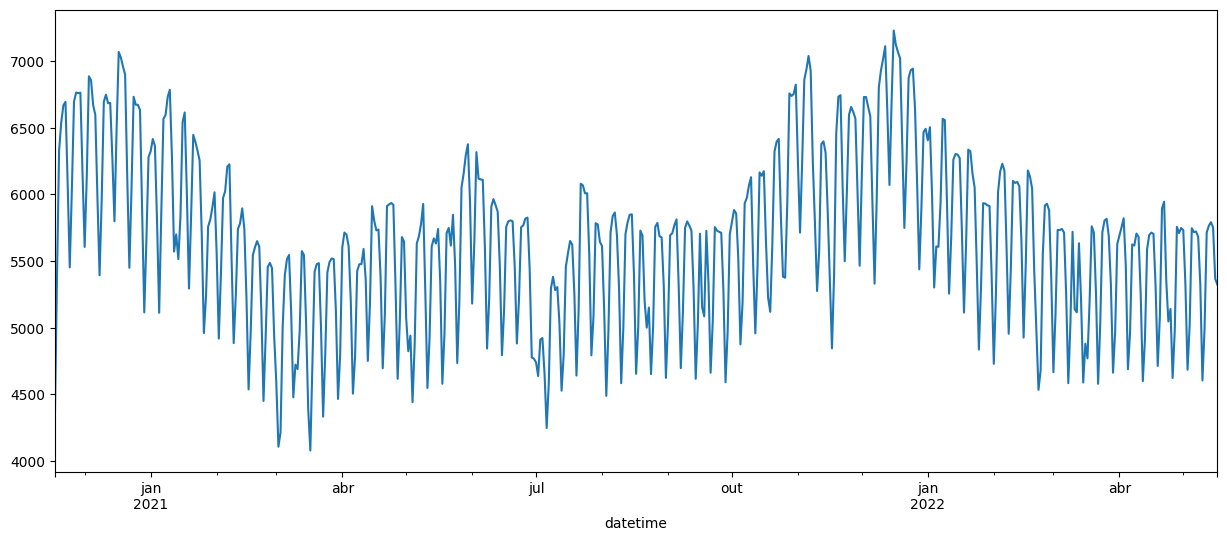

In [67]:
series_d.plot(figsize=(15, 6))

In [58]:
train.tail()

datetime
2022-04-19    4713.125000
2022-04-20    5082.458333
2022-04-21    5892.458333
2022-04-22    5944.333333
2022-04-23    5353.125000
Freq: D, Name: load, dtype: float64

In [59]:
test.head()

datetime
2022-04-24    5046.750000
2022-04-25    5140.208333
2022-04-26    4622.708333
2022-04-27    4978.291667
2022-04-28    5756.291667
Freq: D, Name: Actual, dtype: float64

In [70]:
series_d['2021-01'].mean()

6017.059139784946

In [71]:
from src.tde import UnivariateTDE

In [72]:
# prever o próximo valor com base nos 6 anteriores
series_d_tde = UnivariateTDE(series_d.diff(), horizon=1, k=6)
series_d_tde.head()

t-5         t-4         t-3         t-2         t-1         t-0  \
0  1078.437500  955.875000  209.708333  127.500000   26.375000 -603.916667   
1   955.875000  209.708333  127.500000   26.375000 -603.916667 -636.416667   
2   209.708333  127.500000   26.375000 -603.916667 -636.416667  588.041667   
3   127.500000   26.375000 -603.916667 -636.416667  588.041667  654.416667   
4    26.375000 -603.916667 -636.416667  588.041667  654.416667   68.125000   

          t+1  
0 -636.416667  
1  588.041667  
2  654.416667  
3   68.125000  
4   -4.833333

In [73]:
# separar variáveis explicativas da variável objetivo
X = series_d_tde.drop('t+1', axis=1)
y = series_d_tde['t+1']


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [75]:
X_train.head()

t-5         t-4         t-3         t-2         t-1         t-0
0  1078.437500  955.875000  209.708333  127.500000   26.375000 -603.916667
1   955.875000  209.708333  127.500000   26.375000 -603.916667 -636.416667
2   209.708333  127.500000   26.375000 -603.916667 -636.416667  588.041667
3   127.500000   26.375000 -603.916667 -636.416667  588.041667  654.416667
4    26.375000 -603.916667 -636.416667  588.041667  654.416667   68.125000

In [76]:
y_train.head()

0   -636.416667
1    588.041667
2    654.416667
3     68.125000
4     -4.833333
Name: t+1, dtype: float64

In [77]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [78]:
cv = TimeSeriesSplit(n_splits=5)

cv_err = []
for tr_idx, ts_idx in cv.split(X_train, y_train):
    print('Training indices:')
    print(tr_idx[-5:])
    X_tr = X_train.values[tr_idx]
    y_tr = y_train.values[tr_idx]

    X_vl = X_train.values[ts_idx]
    y_vl = y_train.values[ts_idx]

    print('Training the model')
    model = Ridge()

    model.fit(X_tr, y_tr)
    print('Making predictions')
    pred = model.predict(X_vl)

    print('Computing error')
    err = mean_absolute_error(y_vl, pred)
    cv_err.append(err)

    
print(cv_err)

Training indices:
[67 68 69 70 71]
Training the model
Making predictions
Computing error
Training indices:
[139 140 141 142 143]
Training the model
Making predictions
Computing error
Training indices:
[211 212 213 214 215]
Training the model
Making predictions
Computing error
Training indices:
[283 284 285 286 287]
Training the model
Making predictions
Computing error
Training indices:
[355 356 357 358 359]
Training the model
Making predictions
Computing error
[172.70209534956695, 145.49668462162805, 178.0515066537929, 175.67671733737538, 165.12162769768372]


In [79]:
# erro estimado em validação cruzada
print(f'Average error is: {np.mean(cv_err)}')

Average error is: 167.4097263320094


In [80]:
model_list = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=10),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
}

from sklearn.model_selection import cross_val_score

In [81]:
err_by_method = {}
for method in model_list:
    print(f'Running model: {method}')
    cv_error = cross_val_score(model_list[method],
                               X_train,
                               y_train,
                               cv=cv,
                               scoring='neg_mean_absolute_error')

    err_by_method[method] = -np.mean(cv_error)

Running model: Ridge
Running model: Lasso
Running model: RandomForestRegressor
Running model: DecisionTreeRegressor
Running model: KNeighborsRegressor


<Axes: >

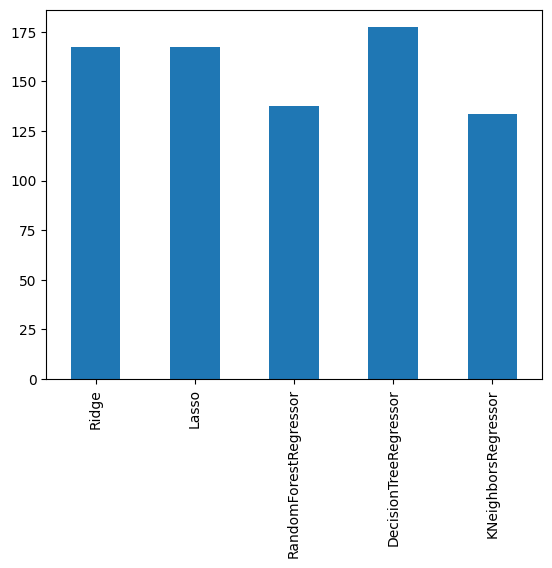

In [82]:
pd.Series(err_by_method).plot.bar()

In [83]:
from pprint import pprint
pprint(err_by_method)

{'DecisionTreeRegressor': 177.2226215780999,
 'KNeighborsRegressor': 133.71976429146534,
 'Lasso': 167.40907331201265,
 'RandomForestRegressor': 137.68276753220613,
 'Ridge': 167.40972633200943}


In [84]:
from sklearn.model_selection import GridSearchCV


parameters = {'weights': ['uniform', 'distance'],
              'n_neighbors': [1, 5, 10]}

In [85]:
model = KNeighborsRegressor()
cv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           cv=cv, 
                           refit=True)

In [86]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 5, 10],
                         'weights': ['uniform', 'distance']})

In [87]:
grid_search.best_estimator_

KNeighborsRegressor(n_neighbors=10, weights='distance')

In [88]:
pred_test_best = grid_search.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test_best)
print(f'Test error is: {err_test}')

Test error is: 107.40583827436045


## Descrever o impacto no desempenho

### Diferentes horizontes temporais

In [109]:
# analisar auto-correlação para verificar os diferentes padrões sazonais
from pmdarima.arima import nsdiffs, ndiffs
from pmdarima.utils import plot_acf, plot_pacf

/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


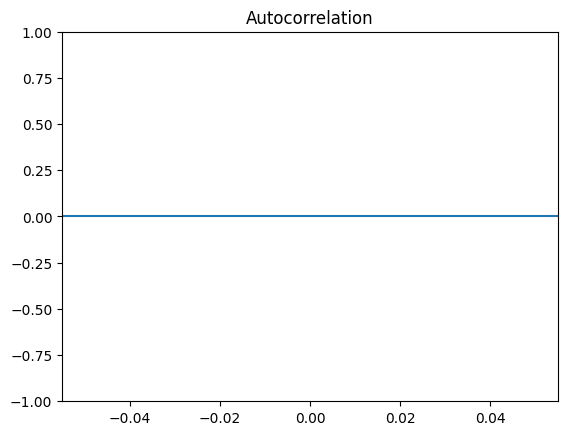

In [110]:
plt = plot_acf(series, lags=48)

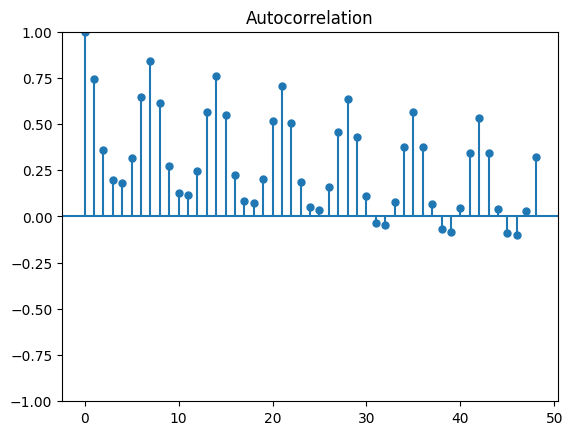

In [112]:
plt = plot_acf(series_d, lags=48)

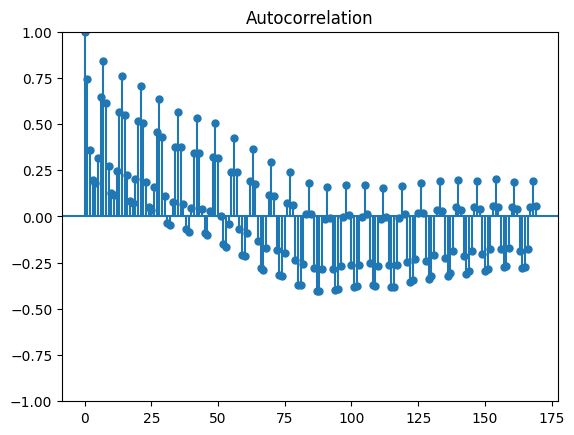

In [113]:
plt = plot_acf(series_d, lags=24 * 7 + 1)

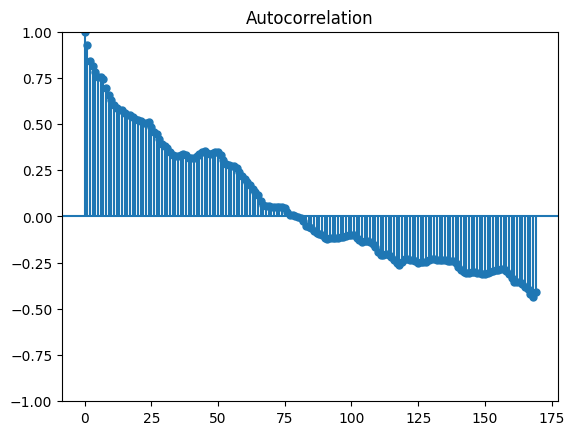

In [114]:
series_d2 = series_d.diff(24*7)[(24*7):]

plt = plot_acf(series_d2, lags=24*7 + 1)

In [123]:
train, test = train_test_split(series, test_size=48, shuffle=False)
train = train.tail(100)


In [125]:
from pmdarima import auto_arima

arima_model = auto_arima(train, seasonal=True, m=24, trace=True)
y_arima_forecast = arima_model.predict(n_periods=48)

print(np.mean(abs(test - y_arima_forecast)))

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,1,1)[24]             : AIC=804.938, Time=16.63 sec
 ARIMA(0,2,0)(0,1,0)[24]             : AIC=828.054, Time=0.13 sec
 ARIMA(1,2,0)(1,1,0)[24]             : AIC=814.868, Time=3.99 sec
 ARIMA(0,2,1)(0,1,1)[24]             : AIC=802.458, Time=4.68 sec
 ARIMA(0,2,1)(0,1,0)[24]             : AIC=803.039, Time=0.21 sec
 ARIMA(0,2,1)(1,1,1)[24]             : AIC=804.398, Time=4.16 sec
 ARIMA(0,2,1)(0,1,2)[24]             : AIC=804.340, Time=18.16 sec
 ARIMA(0,2,1)(1,1,0)[24]             : AIC=802.497, Time=3.00 sec
 ARIMA(0,2,1)(1,1,2)[24]             : AIC=inf, Time=28.96 sec
 ARIMA(0,2,0)(0,1,1)[24]             : AIC=825.327, Time=6.93 sec
 ARIMA(1,2,1)(0,1,1)[24]             : AIC=803.858, Time=6.00 sec
 ARIMA(0,2,2)(0,1,1)[24]             : AIC=802.840, Time=8.79 sec
 ARIMA(1,2,0)(0,1,1)[24]             : AIC=814.727, Time=2.73 sec
 ARIMA(1,2,2)(0,1,1)[24]             : AIC=798.730, Time=7.94 sec
 ARIMA(1,2,2)(0,1,0)[24]          

In [ ]:
# %pip install tbats
# from tbats import TBATS

# # treinar o modelo
# estimator = TBATS(seasonal_periods=(24, 24 * 7, 24 * 7 * 4))
# model = estimator.fit(train)
# # Forecast 48 days ahead
# y_tbats_forecast = model.forecast(steps=48)

# print(np.mean(abs(test - y_tbats_forecast)))

In [131]:
%pip install --upgrade prophet
from prophet import Prophet

model = Prophet(weekly_seasonality=True,
                daily_seasonality=True,
                yearly_seasonality=True)

# é possível adicionar sazonalidades específicas
model = model.add_seasonality(name='monthly', period=24 * 7 * 4, fourier_order=10)

train_df = train.reset_index()
train_df.columns = ['ds', 'y']

#model.fit(train_df.tail(1000))
model.fit(train_df)

y_prophet_forecast = model.make_future_dataframe(periods=48,
                                       include_history=False,
                                       freq='H')
y_prophet_forecast = model.predict(y_prophet_forecast)

  Using cached holidays-0.53-py3-none-any.whl.metadata (23 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 21.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.5 MB/s eta 0:00:00
Using cached holidays-0.53-py3-none-any.whl (1.0 MB)
Using cached tqdm-4.66.4-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [132]:
train_df.head()

ds       y
0 2022-05-11 05:00:00  4729.0
1 2022-05-11 06:00:00  4966.0
2 2022-05-11 07:00:00  5458.0
3 2022-05-11 08:00:00  5204.0
4 2022-05-11 09:00:00  4785.0

/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


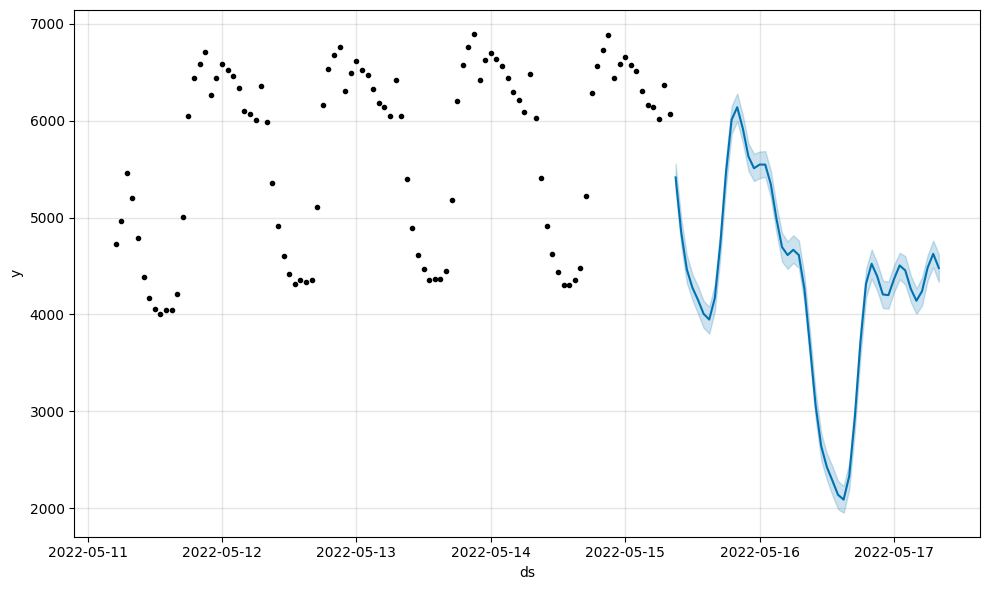

In [133]:
fig1 = model.plot(y_prophet_forecast)

/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime

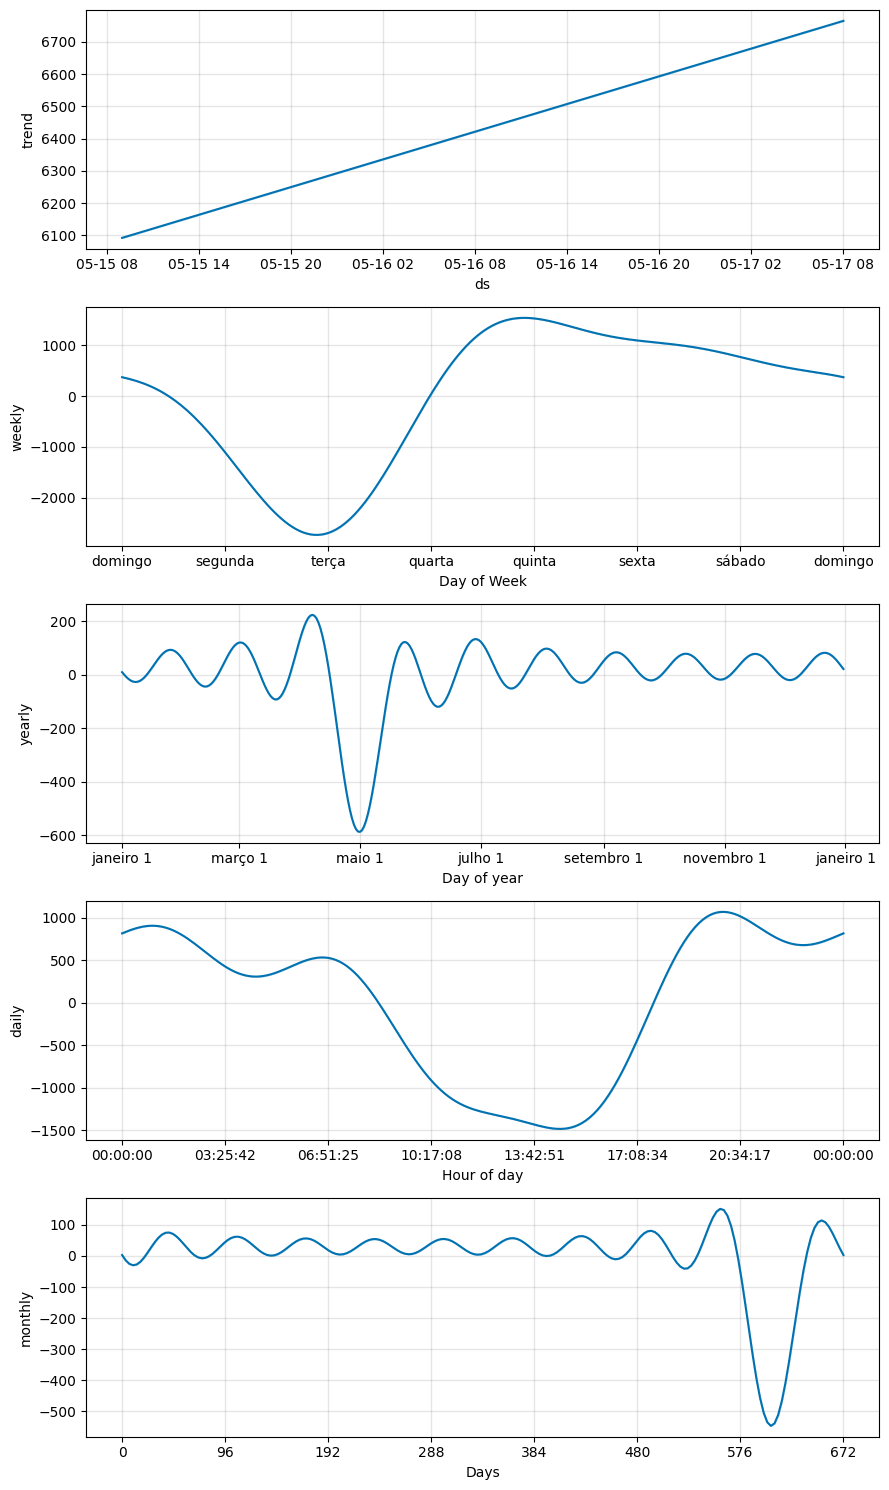

In [134]:
fig2 = model.plot_components(y_prophet_forecast)

/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


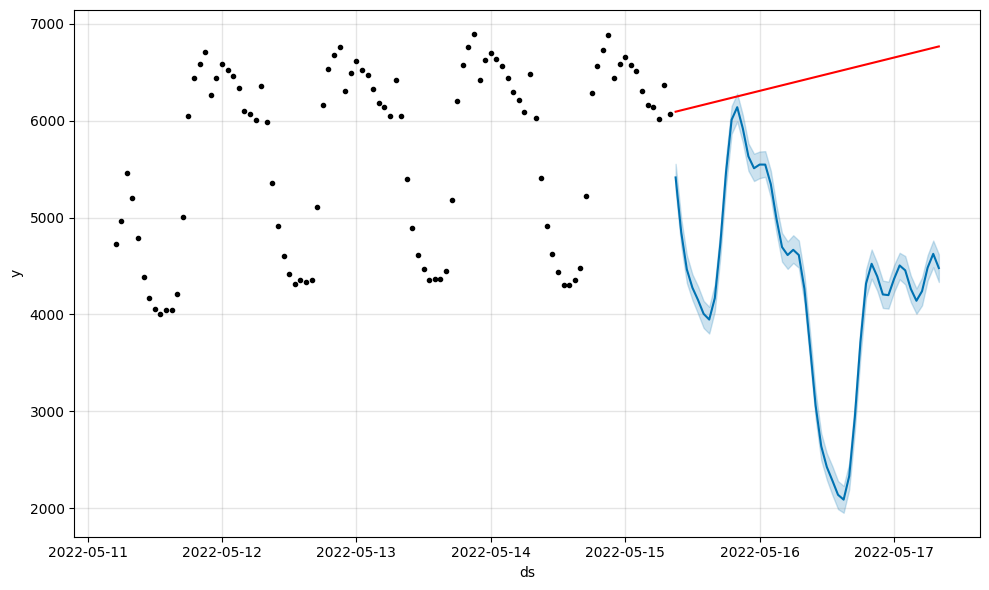

In [135]:
from prophet.plot import add_changepoints_to_plot

fig = model.plot(y_prophet_forecast)
a = add_changepoints_to_plot(fig.gca(), model, y_prophet_forecast)



In [136]:
print(np.mean(abs(test - y_prophet_forecast['yhat'].values)))

1050.6310969973813


In [137]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import mean_absolute_error as mae
from src.prophet import optimize_prophet

params_grid = {'seasonality_mode': ['multiplicative', 'additive'],
               'growth': ['linear', 'flat'],
               'changepoint_prior_scale': [0.01,0.1, 0.25, 0.5],
               'seasonality_prior_scale': [0.01,0.5, 1, 5, 10],
               'n_changepoints': [0, 1, 2, 10]}


grid = ParameterGrid(params_grid)

train_in, validation = train_test_split(train, test_size=48, shuffle=False)

train_in_df = train_in.reset_index()
train_in_df.columns = ['ds', 'y']

val_results = {'losses': [], 'params': []}
for params in grid:
    print(params)
    model = Prophet(seasonality_mode=params['seasonality_mode'],
                    growth=params['growth'],
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    yearly_seasonality=False,
                    n_changepoints=params['n_changepoints'],
                    changepoint_prior_scale=params['changepoint_prior_scale'])
    
    model = model.fit(train_in_df)

    forecast = model.make_future_dataframe(periods=48,
                                           include_history=False,
                                           freq='H')
    forecast = model.predict(forecast)
    forecast = forecast.filter(items=['ds', 'yhat'])

    loss = mae(validation, forecast['yhat'].values)

    val_results['losses'].append(loss)
    val_results['params'].append(params)

idx_params = np.argmin(val_results['losses'])
params = val_results['params'][idx_params]

17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:31 - cmdstanpy - INFO - Chain [1] start processing
17:39:31 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:31 - cmdstanpy - INFO - Chain [1] start processing
17:39:31 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:39:31 - cmdstanpy - INFO - Chain [1] start processing
17:39:31 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:31 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:39:32 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:33 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:39:33 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:35 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:39:35 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:38 - cmdstanpy - INFO - Chain [1] start processing
17:39:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:38 - cmdstanpy - INFO - Chain [1] start processing
17:39:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:40 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:39:40 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:40 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:39:40 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:41 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:39:41 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:41 - cmdstanpy - INFO - Chain [1] start processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:41 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:39:42 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:43 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:39:43 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:43 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:43 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:44 - cmdstanpy - INFO - Chain [1] start processing
17:39:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:44 - cmdstanpy - INFO - Chain [1] start processing
17:39:44 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:44 - cmdstanpy - INFO - Chain [1] start processing
17:39:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:44 - cmdstanpy - INFO - Chain [1] start processing
17:39:44 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:45 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:39:45 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:45 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


17:39:45 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:45 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


17:39:46 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:46 - cmdstanpy - INFO - Chain [1] start processing
17:39:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:46 - cmdstanpy - INFO - Chain [1] start processing
17:39:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:46 - cmdstanpy - INFO - Chain [1] start processing
17:39:46 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:47 - cmdstanpy - INFO - Chain [1] start processing
17:39:47 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:47 - cmdstanpy - INFO - Chain [1] start processing
17:39:47 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:47 - cmdstanpy - INFO - Chain [1] start processing
17:39:47 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:47 - cmdstanpy - INFO - Chain [1] start processing
17:39:47 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:48 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:39:48 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:48 - cmdstanpy - INFO - Chain [1] start processing
17:39:48 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:48 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


17:39:48 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:49 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:39:49 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:50 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:39:50 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:51 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


17:39:51 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:52 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:39:52 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:52 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:39:54 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:55 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:39:57 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:39:57 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:40:00 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:00 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:40:03 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:03 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:40:06 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:08 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:40:08 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:08 - cmdstanpy - INFO - Chain [1] start processing
17:40:08 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:08 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:10 - cmdstanpy - INFO - Chain [1] start processing
17:40:10 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:10 - cmdstanpy - INFO - Chain [1] start processing
17:40:10 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:40:10 - cmdstanpy - INFO - Chain [1] start processing
17:40:10 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:10 - cmdstanpy - INFO - Chain [1] start processing
17:40:10 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:11 - cmdstanpy - INFO - Chain [1] start processing
17:40:11 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:40:11 - cmdstanpy - INFO - Chain [1] start processing
17:40:11 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:11 - cmdstanpy - INFO - Chain [1] start processing
17:40:11 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:11 - cmdstanpy - INFO - Chain [1] start processing
17:40:11 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:11 - cmdstanpy - INFO - Chain [1] start processing
17:40:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:12 - cmdstanpy - INFO - Chain [1] start processing
17:40:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:12 - cmdstanpy - INFO - Chain [1] start processing
17:40:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:12 - cmdstanpy - INFO - Chain [1] start processing
17:40:12 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:16 - cmdstanpy - INFO - Chain [1] start processing
17:40:16 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:16 - cmdstanpy - INFO - Chain [1] start processing
17:40:16 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:16 - cmdstanpy - INFO - Chain [1] start processing
17:40:16 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:16 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:40:17 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:17 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:40:17 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:17 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:40:18 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:18 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:40:18 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:18 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:40:19 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:19 - cmdstanpy - INFO - Chain [1] start processing
17:40:19 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:19 - cmdstanpy - INFO - Chain [1] start processing
17:40:19 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:20 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:20 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:20 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:20 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:40:21 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:21 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:40:21 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:21 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:40:22 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:22 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:40:22 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:22 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:40:23 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:23 - cmdstanpy - INFO - Chain [1] start processing
17:40:23 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:40:23 - cmdstanpy - INFO - Chain [1] start processing
17:40:23 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:23 - cmdstanpy - INFO - Chain [1] start processing
17:40:23 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:23 - cmdstanpy - INFO - Chain [1] start processing
17:40:23 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:40:24 - cmdstanpy - INFO - Chain [1] start processing
17:40:24 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:24 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:40:24 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:24 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:40:25 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:25 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:40:25 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:25 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:40:26 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:26 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:40:26 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:26 - cmdstanpy - INFO - Chain [1] start processing
17:40:26 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


17:40:27 - cmdstanpy - INFO - Chain [1] start processing
17:40:27 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:27 - cmdstanpy - INFO - Chain [1] start processing
17:40:27 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:27 - cmdstanpy - INFO - Chain [1] start processing
17:40:27 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:27 - cmdstanpy - INFO - Chain [1] start processing
17:40:27 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:29 - cmdstanpy - INFO - Chain [1] start processing
17:40:29 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:29 - cmdstanpy - INFO - Chain [1] start processing
17:40:29 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:29 - cmdstanpy - INFO - Chain [1] start processing
17:40:29 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:30 - cmdstanpy - INFO - Chain [1] start processing
17:40:30 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


17:40:30 - cmdstanpy - INFO - Chain [1] start processing
17:40:30 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:30 - cmdstanpy - INFO - Chain [1] start processing
17:40:30 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:40:30 - cmdstanpy - INFO - Chain [1] start processing
17:40:30 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:31 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:40:31 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:31 - cmdstanpy - INFO - Chain [1] start processing
17:40:31 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:31 - cmdstanpy - INFO - Chain [1] start processing
17:40:31 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:32 - cmdstanpy - INFO - Chain [1] start processing
17:40:32 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:32 - cmdstanpy - INFO - Chain [1] start processing
17:40:32 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:32 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:40:33 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:33 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


17:40:33 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:33 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


17:40:33 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:34 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:40:34 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:34 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:40:34 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:35 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:40:35 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:35 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:40:35 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:36 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:40:36 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:36 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:40:36 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:36 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:40:37 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:37 - cmdstanpy - INFO - Chain [1] start processing
17:40:37 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:37 - cmdstanpy - INFO - Chain [1] start processing
17:40:37 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:37 - cmdstanpy - INFO - Chain [1] start processing
17:40:37 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:40:37 - cmdstanpy - INFO - Chain [1] start processing
17:40:37 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:38 - cmdstanpy - INFO - Chain [1] start processing
17:40:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:38 - cmdstanpy - INFO - Chain [1] start processing
17:40:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:38 - cmdstanpy - INFO - Chain [1] start processing
17:40:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:38 - cmdstanpy - INFO - Chain [1] start processing
17:40:38 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:40 - cmdstanpy - INFO - Chain [1] start processing
17:40:40 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:40 - cmdstanpy - INFO - Chain [1] start processing
17:40:40 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:40 - cmdstanpy - INFO - Chain [1] start processing
17:40:40 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:40:40 - cmdstanpy - INFO - Chain [1] start processing
17:40:40 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:41 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:41 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:41 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:41 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:42 - cmdstanpy - INFO - Chain [1] start processing
17:40:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:42 - cmdstanpy - INFO - Chain [1] start processing
17:40:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:42 - cmdstanpy - INFO - Chain [1] start processing
17:40:42 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:42 - cmdstanpy - INFO - Chain [1] start processing
17:40:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:43 - cmdstanpy - INFO - Chain [1] start processing
17:40:43 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:43 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:40:44 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:44 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:40:44 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:44 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:40:45 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:45 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:40:45 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:45 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:40:46 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:46 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:40:46 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:46 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


17:40:46 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:47 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


17:40:47 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:47 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:40:48 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:48 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:40:48 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:48 - cmdstanpy - INFO - Chain [1] start processing
17:40:48 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:48 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:50 - cmdstanpy - INFO - Chain [1] start processing
17:40:50 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:50 - cmdstanpy - INFO - Chain [1] start processing
17:40:50 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:50 - cmdstanpy - INFO - Chain [1] start processing
17:40:50 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:50 - cmdstanpy - INFO - Chain [1] start processing
17:40:50 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:50 - cmdstanpy - INFO - Chain [1] start processing
17:40:50 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:51 - cmdstanpy - INFO - Chain [1] start processing
17:40:51 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:51 - cmdstanpy - INFO - Chain [1] start processing
17:40:51 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:51 - cmdstanpy - INFO - Chain [1] start processing
17:40:51 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:40:51 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:54 - cmdstanpy - INFO - Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:54 - cmdstanpy - INFO - Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:54 - cmdstanpy - INFO - Chain [1] start processing
17:40:55 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:55 - cmdstanpy - INFO - Chain [1] start processing
17:40:55 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:55 - cmdstanpy - INFO - Chain [1] start processing
17:40:55 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:56 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:40:56 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:56 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:40:56 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:57 - cmdstanpy - INFO - Chain [1] start processing
17:40:57 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:57 - cmdstanpy - INFO - Chain [1] start processing
17:40:57 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:57 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:40:57 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:58 - cmdstanpy - INFO - Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:58 - cmdstanpy - INFO - Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:58 - cmdstanpy - INFO - Chain [1] start processing
17:40:58 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:58 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


17:40:59 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.25, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:40:59 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:41:00 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:00 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:41:00 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:01 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:41:01 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:01 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:41:02 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:02 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:41:02 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:04 - cmdstanpy - INFO - Chain [1] start processing
17:41:04 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:04 - cmdstanpy - INFO - Chain [1] start processing
17:41:04 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:04 - cmdstanpy - INFO - Chain [1] start processing
17:41:04 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:04 - cmdstanpy - INFO - Chain [1] start processing
17:41:04 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:07 - cmdstanpy - INFO - Chain [1] start processing
17:41:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:07 - cmdstanpy - INFO - Chain [1] start processing
17:41:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:07 - cmdstanpy - INFO - Chain [1] start processing
17:41:07 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:07 - cmdstanpy - INFO - Chain [1] start processing
17:41:08 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:08 - cmdstanpy - INFO - Chain [1] start processing
17:41:08 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:08 - cmdstanpy - INFO - Chain [1] start processing
17:41:08 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:08 - cmdstanpy - INFO - Chain [1] start processing
17:41:08 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:08 - cmdstanpy - INFO - Chain [1] start processing
17:41:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:09 - cmdstanpy - INFO - Chain [1] start processing
17:41:09 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:09 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:41:09 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:10 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:41:10 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:10 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


17:41:11 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:11 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:41:11 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:11 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


17:41:12 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:12 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:41:12 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:12 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


17:41:13 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:13 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


17:41:13 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:13 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:41:14 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:17 - cmdstanpy - INFO - Chain [1] start processing
17:41:17 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:17 - cmdstanpy - INFO - Chain [1] start processing
17:41:17 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:17 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


17:41:17 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:17 - cmdstanpy - INFO - Chain [1] start processing
17:41:17 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:17 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


17:41:17 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}
{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:20 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


17:41:20 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:21 - cmdstanpy - INFO - Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:21 - cmdstanpy - INFO - Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing
/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


17:41:21 - cmdstanpy - INFO - Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:22 - cmdstanpy - INFO - Chain [1] start processing
17:41:22 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
17:41:22 - cmdstanpy - INFO - Chain [1] start processing
17:41:22 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'growth': 'flat', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [138]:
params

{'changepoint_prior_scale': 0.5,
 'growth': 'linear',
 'n_changepoints': 2,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 0.01}

In [139]:
model = Prophet(weekly_seasonality=True,
                daily_seasonality=True,
                yearly_seasonality=False,
                **params)

model = model.add_seasonality(name='monthly', period=24 * 7 * 4, fourier_order=10)

model.fit(train_df)

y_prophetopt_forecast = model.make_future_dataframe(periods=test.shape[0],
                                       include_history=False,
                                       freq='H')
y_prophetopt_forecast = model.predict(y_prophetopt_forecast)
y_prophetopt_forecast = y_prophet_forecast.filter(items=['ds', 'yhat'])

print(np.mean(abs(test - y_prophetopt_forecast['yhat'].values)))


17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing


1050.6310969973813


/home/rp/Desenvolvimento/Data Science/M3 - Segunda Tarefa/.venv/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [140]:
train

datetime
2022-05-11 05:00:00    4729.0
2022-05-11 06:00:00    4966.0
2022-05-11 07:00:00    5458.0
2022-05-11 08:00:00    5204.0
2022-05-11 09:00:00    4785.0
                        ...  
2022-05-15 04:00:00    6161.0
2022-05-15 05:00:00    6144.0
2022-05-15 06:00:00    6013.0
2022-05-15 07:00:00    6369.0
2022-05-15 08:00:00    6070.0
Name: load, Length: 100, dtype: float64

In [146]:
from src.tde import time_delay_embedding
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, Lasso

train_df = time_delay_embedding(train, n_lags=24, horizon=48)
train_df = train_df.dropna()
target_columns = train_df.columns.str.contains('t+')
X = train_df.iloc[:, ~target_columns]
Y = train_df.iloc[:, target_columns]

train_df.head()

t-23    t-22    t-21    t-20    t-19    t-18    t-17  \
datetime                                                                      
2022-05-12 05:00:00  4729.0  4966.0  5458.0  5204.0  4785.0  4384.0  4167.0   
2022-05-12 06:00:00  4966.0  5458.0  5204.0  4785.0  4384.0  4167.0  4056.0   
2022-05-12 07:00:00  5458.0  5204.0  4785.0  4384.0  4167.0  4056.0  4006.0   
2022-05-12 08:00:00  5204.0  4785.0  4384.0  4167.0  4056.0  4006.0  4048.0   
2022-05-12 09:00:00  4785.0  4384.0  4167.0  4056.0  4006.0  4048.0  4047.0   

                       t-16    t-15    t-14  ...    t+39    t+40    t+41  \
datetime                                     ...                           
2022-05-12 05:00:00  4056.0  4006.0  4048.0  ...  6573.0  6756.0  6894.0   
2022-05-12 06:00:00  4006.0  4048.0  4047.0  ...  6756.0  6894.0  6420.0   
2022-05-12 07:00:00  4048.0  4047.0  4209.0  ...  6894.0  6420.0  6622.0   
2022-05-12 08:00:00  4047.0  4209.0  5002.0  ...  6420.0  6622.0  6700.0   
2022-05-12 09:00:00  4209.0  5002.0  6051.0  ...  6622.0  6700.0  6635.0   

                       t+42    t+43    t+44    t+45    t+46    t+47    t+48  
datetime                                                                     
2022-05-12 05:00:00  6420.0  6622.0  6700.0  6635.0  6565.0  6437.0  6297.0  
2022-05-12 06:00:00  6622.0  6700.0  6635.0  6565.0  6437.0  6297.0  6216.0  
2022-05-12 07:00:00  6700.0  6635.0  6565.0  6437.0  6297.0  6216.0  6086.0  
2022-05-12 08:00:00  6635.0  6565.0  6437.0  6297.0  6216.0  6086.0  6476.0  
2022-05-12 09:00:00  6565.0  6437.0  6297.0  6216.0  6086.0  6476.0  6030.0  

[5 rows x 72 columns]

In [147]:
test_dummy = pd.Series(np.repeat(np.nan, 48), index=test.index)
test_df = time_delay_embedding(pd.concat([train.tail(24), test_dummy]), n_lags=24, horizon=48)
test_df = test_df.loc[test.head(1).index, :]
X_test = test_df.iloc[:, ~target_columns]
X_test

Empty DataFrame
Columns: []
Index: [2022-05-15 09:00:00]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 12.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='datetime'>

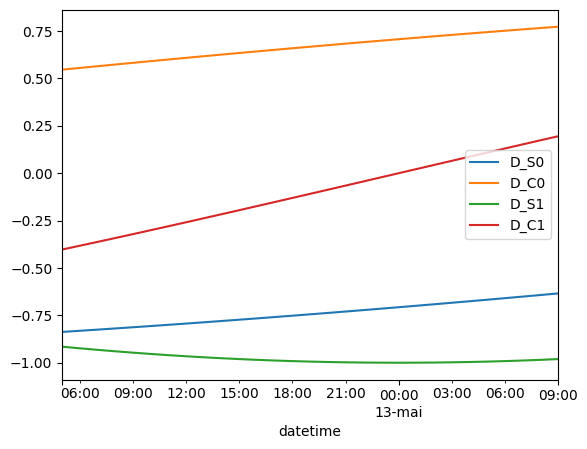

In [149]:
%pip install sklego
from src.seasonality import FourierTerms

daily_terms = FourierTerms(period=24, n_terms=2, prefix='D_')
daily_fourier = daily_terms.transform(train_df.index)

daily_fourier.head(600).plot()

<Axes: xlabel='datetime'>

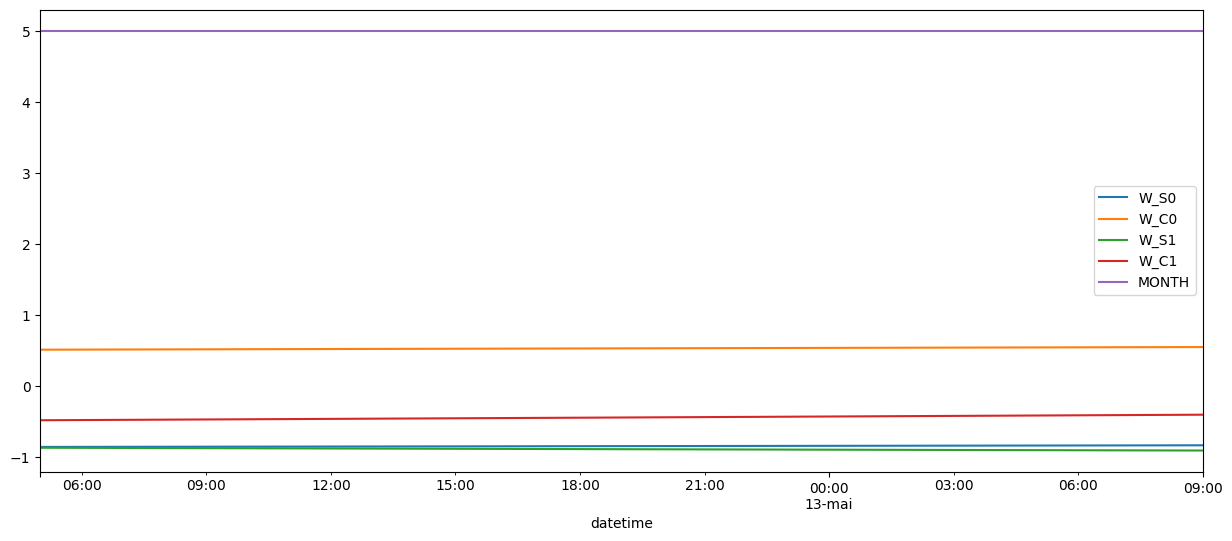

In [150]:
from src.seasonality import FourierTerms

daily_terms = FourierTerms(period=24, n_terms=2, prefix='D_')
weekly_terms = FourierTerms(period=24 * 7, n_terms=2, prefix='W_')
monthly_terms = FourierTerms(period=24 * 30, n_terms=2, prefix='M_')

daily_fourier = daily_terms.transform(train_df.index)
weekly_fourier = weekly_terms.transform(train_df.index)
monthly_fourier = monthly_terms.transform(train_df.index)

weekly_fourier['MONTH'] = train_df.index.month

#daily_fourier.tail(400).plot(figsize=(15,6))
weekly_fourier.plot(figsize=(15,6))

In [151]:
weekly_fourier['MONTH']

datetime
2022-05-12 05:00:00    5
2022-05-12 06:00:00    5
2022-05-12 07:00:00    5
2022-05-12 08:00:00    5
2022-05-12 09:00:00    5
2022-05-12 10:00:00    5
2022-05-12 11:00:00    5
2022-05-12 12:00:00    5
2022-05-12 13:00:00    5
2022-05-12 14:00:00    5
2022-05-12 15:00:00    5
2022-05-12 16:00:00    5
2022-05-12 17:00:00    5
2022-05-12 18:00:00    5
2022-05-12 19:00:00    5
2022-05-12 20:00:00    5
2022-05-12 21:00:00    5
2022-05-12 22:00:00    5
2022-05-12 23:00:00    5
2022-05-13 00:00:00    5
2022-05-13 01:00:00    5
2022-05-13 02:00:00    5
2022-05-13 03:00:00    5
2022-05-13 04:00:00    5
2022-05-13 05:00:00    5
2022-05-13 06:00:00    5
2022-05-13 07:00:00    5
2022-05-13 08:00:00    5
2022-05-13 09:00:00    5
Name: MONTH, dtype: int32

<Axes: xlabel='datetime'>

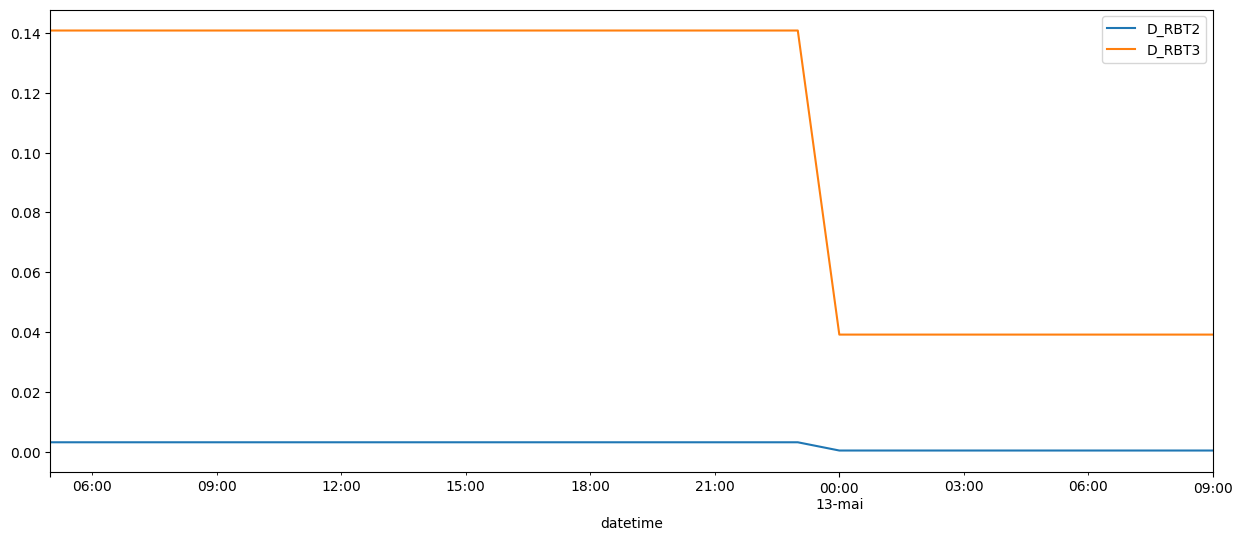

In [152]:
from src.seasonality import RBFTerms

rbf_hour = RBFTerms(n_terms=12, period='.hour', prefix='H_')
rbf_day = RBFTerms(n_terms=12, period='.day', prefix='D_')

rbf_hour.fit(train_df.index)
rbf_day.fit(train_df.index)

rbf_hour_x = rbf_hour.transform(train_df.index)
rbf_day_x = rbf_day.transform(train_df.index)

rbf_day_x.iloc[:,2:4].tail(1400).plot(figsize=(15,6))

In [153]:
from src.seasonality import FourierTerms, RBFTerms

daily_terms = FourierTerms(period=24, n_terms=2, prefix='D_')
weekly_terms = FourierTerms(period=24 * 7, n_terms=2, prefix='W_')
monthly_terms = FourierTerms(period=24 * 30, n_terms=2, prefix='M_')

rbf_hour = RBFTerms(n_terms=12, period='.hour', prefix='H_')
rbf_day = RBFTerms(n_terms=12, period='.day', prefix='D_')

rbf_hour.fit(train_df.index)
rbf_day.fit(train_df.index)

rbf_hour_x = rbf_hour.transform(train_df.index)
rbf_day_x = rbf_day.transform(train_df.index)
daily_fourier = daily_terms.transform(train_df.index)
weekly_fourier = weekly_terms.transform(train_df.index)
monthly_fourier = monthly_terms.transform(train_df.index)

X_exog = pd.concat([X, daily_fourier, weekly_fourier, monthly_fourier,
                    rbf_hour_x, rbf_day_x],
                   ignore_index=False, axis=1)
X_exog


D_S0      D_C0      D_S1          D_C1      W_S0  \
datetime                                                                    
2022-05-12 05:00:00 -0.837480  0.546467 -0.915311 -4.027467e-01 -0.862103   
2022-05-12 06:00:00 -0.831470  0.555570 -0.923880 -3.826834e-01 -0.861313   
2022-05-12 07:00:00 -0.825360  0.564607 -0.932008 -3.624380e-01 -0.860520   
2022-05-12 08:00:00 -0.819152  0.573576 -0.939693 -3.420201e-01 -0.859725   
2022-05-12 09:00:00 -0.812847  0.582478 -0.946930 -3.214395e-01 -0.858928   
2022-05-12 10:00:00 -0.806445  0.591310 -0.953717 -3.007058e-01 -0.858129   
2022-05-12 11:00:00 -0.799947  0.600071 -0.960050 -2.798290e-01 -0.857328   
2022-05-12 12:00:00 -0.793353  0.608761 -0.965926 -2.588190e-01 -0.856525   
2022-05-12 13:00:00 -0.786666  0.617379 -0.971342 -2.376859e-01 -0.855719   
2022-05-12 14:00:00 -0.779884  0.625923 -0.976296 -2.164396e-01 -0.854912   
2022-05-12 15:00:00 -0.773010  0.634393 -0.980785 -1.950903e-01 -0.854102   
2022-05-12 16:00:00 -0.766044  0.642788 -0.984808 -1.736482e-01 -0.853291   
2022-05-12 17:00:00 -0.758987  0.651105 -0.988362 -1.521234e-01 -0.852477   
2022-05-12 18:00:00 -0.751840  0.659346 -0.991445 -1.305262e-01 -0.851662   
2022-05-12 19:00:00 -0.744603  0.667508 -0.994056 -1.088669e-01 -0.850844   
2022-05-12 20:00:00 -0.737277  0.675590 -0.996195 -8.715574e-02 -0.850024   
2022-05-12 21:00:00 -0.729864  0.683592 -0.997859 -6.540313e-02 -0.849202   
2022-05-12 22:00:00 -0.722364  0.691513 -0.999048 -4.361939e-02 -0.848378   
2022-05-12 23:00:00 -0.714778  0.699352 -0.999762 -2.181489e-02 -0.847552   
2022-05-13 00:00:00 -0.707107  0.707107 -1.000000 -1.337154e-12 -0.846724   
2022-05-13 01:00:00 -0.699352  0.714778 -0.999762  2.181489e-02 -0.845894   
2022-05-13 02:00:00 -0.691513  0.722364 -0.999048  4.361939e-02 -0.845062   
2022-05-13 03:00:00 -0.683592  0.729864 -0.997859  6.540313e-02 -0.844228   
2022-05-13 04:00:00 -0.675590  0.737277 -0.996195  8.715574e-02 -0.843391   
2022-05-13 05:00:00 -0.667508  0.744603 -0.994056  1.088669e-01 -0.842553   
2022-05-13 06:00:00 -0.659346  0.751840 -0.991445  1.305262e-01 -0.841713   
2022-05-13 07:00:00 -0.651105  0.758987 -0.988362  1.521234e-01 -0.840870   
2022-05-13 08:00:00 -0.642788  0.766044 -0.984808  1.736482e-01 -0.840026   
2022-05-13 09:00:00 -0.634393  0.773010 -0.980785  1.950903e-01 -0.839179   

                         W_C0      W_S1      W_C1      M_S0      M_C0  ...  \
datetime                                                               ...   
2022-05-12 05:00:00  0.506733 -0.873712 -0.486444 -0.376292 -0.926501  ...   
2022-05-12 06:00:00  0.508075 -0.875223 -0.483719 -0.376629 -0.926364  ...   
2022-05-12 07:00:00  0.509417 -0.876727 -0.480989 -0.376965 -0.926227  ...   
2022-05-12 08:00:00  0.510757 -0.878222 -0.478254 -0.377302 -0.926090  ...   
2022-05-12 09:00:00  0.512096 -0.879708 -0.475515 -0.377639 -0.925953  ...   
2022-05-12 10:00:00  0.513434 -0.881186 -0.472770 -0.377975 -0.925816  ...   
2022-05-12 11:00:00  0.514771 -0.882655 -0.470022 -0.378312 -0.925678  ...   
2022-05-12 12:00:00  0.516106 -0.884115 -0.467269 -0.378649 -0.925541  ...   
2022-05-12 13:00:00  0.517440 -0.885567 -0.464511 -0.378985 -0.925403  ...   
2022-05-12 14:00:00  0.518773 -0.887011 -0.461749 -0.379322 -0.925265  ...   
2022-05-12 15:00:00  0.520105 -0.888446 -0.458982 -0.379658 -0.925127  ...   
2022-05-12 16:00:00  0.521435 -0.889872 -0.456211 -0.379994 -0.924989  ...   
2022-05-12 17:00:00  0.522764 -0.891289 -0.453435 -0.380331 -0.924851  ...   
2022-05-12 18:00:00  0.524092 -0.892698 -0.450655 -0.380667 -0.924712  ...   
2022-05-12 19:00:00  0.525419 -0.894098 -0.447871 -0.381003 -0.924574  ...   
2022-05-12 20:00:00  0.526744 -0.895490 -0.445082 -0.381339 -0.924435  ...   
2022-05-12 21:00:00  0.528068 -0.896873 -0.442289 -0.381675 -0.924296  ...   
2022-05-12 22:00:00  0.529391 -0.898247 -0.439491 -0.382011 -0.924158  ...   
2022-05-12 23:00:00  0.530712 -0.899612 -0.436690 -0.382347 -0.924019  ...   

### Desempenho nos valores extremos da série

In [89]:
series_d_tde.head()

t-5         t-4         t-3         t-2         t-1         t-0  \
0  1078.437500  955.875000  209.708333  127.500000   26.375000 -603.916667   
1   955.875000  209.708333  127.500000   26.375000 -603.916667 -636.416667   
2   209.708333  127.500000   26.375000 -603.916667 -636.416667  588.041667   
3   127.500000   26.375000 -603.916667 -636.416667  588.041667  654.416667   
4    26.375000 -603.916667 -636.416667  588.041667  654.416667   68.125000   

          t+1  
0 -636.416667  
1  588.041667  
2  654.416667  
3   68.125000  
4   -4.833333

In [94]:
is_future = series_d_tde.columns.str.contains('\+')
X = series_d_tde.iloc[:,~is_future]
y = series_d_tde['t+1']

<>:1: SyntaxWarning: invalid escape sequence '\+'
<>:1: SyntaxWarning: invalid escape sequence '\+'
/tmp/ipykernel_27793/2306659713.py:1: SyntaxWarning: invalid escape sequence '\+'
  is_future = series_d_tde.columns.str.contains('\+')


In [96]:
y_train.head()

0   -636.416667
1    588.041667
2    654.416667
3     68.125000
4     -4.833333
Name: t+1, dtype: float64

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [98]:
forecasts = model.predict(X_test)
forecasts


array([-3.37178095e+02,  4.74087147e+02,  7.19993797e+02,  2.46796794e+01,
       -1.36619164e+02, -1.54876241e+02, -7.65405247e+02, -6.59744596e+02,
        1.93671974e+02,  4.93960426e+02, -1.79246918e+02, -3.02036960e+01,
        2.86836632e+01, -5.03535338e+02, -2.74499669e+02,  4.99979657e+02,
        7.09765287e+02,  9.16015156e+01,  4.41224477e+01,  4.81081997e-01,
       -5.80834794e+02, -2.07108001e+02,  3.76312746e+02,  7.61839609e+02,
        2.15517084e+02,  6.28665710e+01,  3.50033593e+01, -4.08714105e+02,
       -4.43038755e+02,  3.18130188e+02,  6.64462364e+02,  3.27823881e+01,
        5.59336372e+02,  6.84259438e+01, -7.04651975e+02, -3.02745416e+02,
       -5.10284691e+01,  3.50402866e+02,  1.13218232e+02,  1.04339805e+02,
        7.60265100e+01, -4.75185216e+02, -3.76634081e+02,  3.25813851e+02,
        6.44695505e+02,  1.84352450e+01, -7.68561310e+01, -2.59698012e+00,
       -4.53341378e+02, -3.34056149e+02,  4.67183307e+02,  7.77284382e+02,
        1.17056075e+02,  

In [99]:
test_data = pd.DataFrame({'forecasts': forecasts, 'actual': y_test})
test_data.head()

forecasts      actual
378 -337.178095 -606.041667
379  474.087147  623.375000
380  719.993797  847.500000
381   24.679679  127.291667
382 -136.619164   85.875000

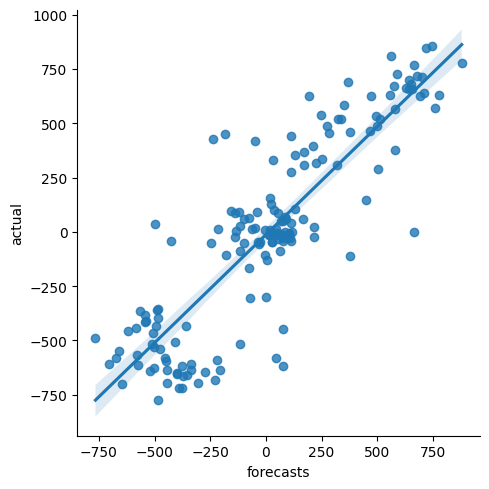

In [100]:
import seaborn as sns
sns.lmplot(x='forecasts', y='actual',data=test_data,fit_reg=True) 

In [101]:
from sklearn.metrics import mean_absolute_error, r2_score
from src.error import MASE

In [102]:
# MASE(y_train, y_test, forecasts)
mean_absolute_error(y_test, forecasts)


165.21586030159543

In [103]:
large_y_test = y_test[y_test > 5]
large_forecasts = forecasts[y_test > 5]
mean_absolute_error(large_y_test, large_forecasts)

147.66008095731476

In [104]:
r2_score(y_test, forecasts)

0.753070227914911

In [105]:
r2_score(large_y_test, large_forecasts)

0.41501003713584583

### Comparação de diferentes algoritmos de regressão

In [158]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Extrair X e y do dataframe
is_future = series_d_tde.columns.str.contains('\\+')
X = series_d_tde.iloc[:, ~is_future]
y = series_d_tde['t+1']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar os modelos
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {"MAE": mae, "R²": r2}

print(results)


{'Linear Regression': {'MAE': 158.3441050241687, 'R²': 0.7778198970775687}, 'Ridge Regression': {'MAE': 158.3441054545843, 'R²': 0.7778198957753971}, 'Random Forest': {'MAE': 123.97868138531047, 'R²': 0.8151493456966423}, 'Gradient Boosting': {'MAE': 123.810798483624, 'R²': 0.8227632974692362}}
